<a href="https://colab.research.google.com/github/agidley/Project01/blob/main/MAE494_DesignOptimization_Project01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# overhead
import logging
import math
import random
import numpy as np
import time
import torch
import torch.nn as nn
from torch import optim
from torch.nn import utils
import matplotlib.pyplot as plt

!pip install ipywidgets
from ipywidgets import IntProgress
from IPython.display import display
from matplotlib import pyplot as plt, rc
from matplotlib.animation import FuncAnimation, PillowWriter
rc('animation', html='jshtml')
!pip install jupyterthemes
from jupyterthemes import jtplot
jtplot.style(theme='grade3', context='notebook', ticks=True, grid=False)

logger = logging.getLogger(__name__)

# Constant Values

In [1]:
# environment parameters
FRAME_TIME = 0.1  # time interval
GRAVITY_ACCEL_Y = 0.12  # gravity constant in Y direction
GRAVITY_ACCEL_X =0.  # gravity constant in X direction
BOOST_ACCEL = 0.18  # thrust constant
OMEGA_RATE = 0.1  # max rotation rate

# Dynamic Model Setup

In [ ]:
class Dynamics(nn.Module):

    def __init__(self):
        super(Dynamics, self).__init__()

    def forward(self, state, action):
        """
        action[0] = Thrust
        action[1] = theta_dot

        state[0] = x
        state[1] = y
        state[2] = vx
        state[3] = vy
        state[4] = theta

        """
        # Apply gravity
        # Note: Here gravity is used to change velocity which is the second element of the state vector
        # Normally, we would do x[1] = x[1] + gravity * delta_time
        # but this is not allowed in PyTorch since it overwrites one variable (x[1]) that is part of the computational graph to be differentiated.
        # Therefore, I define a tensor dx = [0., gravity * delta_time], and do x = x + dx. This is allowed.

        delta_state_gravity = torch.tensor([[0., 0.,-GRAVITY_ACCEL_X * FRAME_TIME, -GRAVITY_ACCEL_Y * FRAME_TIME, 0.]])

        state_tensor = torch.zeros((1, 5))
        state_tensor[0, 3] = torch.cos(state[0, 4])
        state_tensor[0, 2] = torch.sin(state[0, 4])

        delta_state = BOOST_ACCEL * FRAME_TIME * torch.mul(state_tensor, action[0, 0].reshape(-1, 1))

        # Theta
        delta_state_theta = FRAME_TIME * OMEGA_RATE * torch.mul(torch.tensor([0., 0., 0., 0, 1.]),action[0, 1].reshape(-1, 1))

        # Update state
        step_mat = torch.tensor([[1., 0.,FRAME_TIME, 0., 0.],
                                 [0., 1., 0., FRAME_TIME, 0.],
                                 [0., 0., 1., 0., 0.],
                                 [0., 0., 0., 1., 0.],
                                 [0., 0., 0., 0., 1.]])

        shift_mat = torch.tensor([[0., 0.,FRAME_TIME, 0., 0.],
                                 [0., 0., 0., FRAME_TIME, 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.],
                                 [0., 0., 0., 0., 0.]])

        state = torch.matmul(step_mat, state.T) + torch.matmul(shift_mat, delta_state.T)  * 0.5 + torch.matmul(shift_mat, delta_state_gravity.T)  * 0.5
        state = state.T

        state = state + delta_state  + delta_state_gravity + delta_state_theta

        return state

# Controller Setup

In [ ]:
class Controller(nn.Module):
    def __init__(self, dim_input, dim_hidden, dim_output):
        """
        dim_input: # of system states
        dim_output: # of actions
        dim_hidden:
        """
        super(Controller, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(dim_input, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_hidden),
            nn.Tanh(),
            nn.Linear(dim_hidden, dim_output),
            nn.Sigmoid())

    def forward(self, state):
        action = self.network(state)
        action = (action - torch.tensor([0., 0.5]))*2  # bound theta_dot range -1 to 1
        return action

# Minimizing Error in the Controller

In [ ]:
class Simulation(nn.Module):

    def __init__(self, controller, dynamics, T):
        super(Simulation, self).__init__()
        self.state = self.initialize_state()
        self.controller = controller
        self.dynamics = dynamics
        self.T = T
        self.theta_trajectory = torch.empty((1, 0))
        self.u_trajectory = torch.empty((1, 0))

    def forward(self, state):
        self.action_trajectory = []
        self.state_trajectory = []
        for _ in range(T):
            action = self.controller(state)
            state = self.dynamics(state, action)
            self.action_trajectory.append(action)
            self.state_trajectory.append(state)
        return self.error(state)

    @staticmethod
    def initialize_state():
        state = [[2.,4.,0.,0.,-0.5]]
        return torch.tensor(state, requires_grad=False).float()

    def error(self, state):
        return torch.mean(state ** 2)

# Optimization

In [ ]:
class Optimize:

    # create properties of the class (simulation, parameters, optimizer, lost_list). Where to receive input of objects

    def __init__(self, simulation):
        self.simulation = simulation # define the objective function
        self.parameters = simulation.controller.parameters()
        self.optimizer = optim.LBFGS(self.parameters, lr=0.01) # define the opmization algorithm
        self.loss_list = []

    # Define loss calculation method for objective function

    def step(self):
        def closure():
            loss = self.simulation(self.simulation.state)  # calculate the loss of objective function
            self.optimizer.zero_grad()
            loss.backward() # calculate the gradient
            return loss

        self.optimizer.step(closure)
        return closure()

    # Define training method for the model


    def train(self, epochs):
        # self.optimizer = epoch
        l = np.zeros(epochs)
        for epoch in range(epochs):
            self.epoch = epoch
            loss = self.step() # use step function to train the model
            self.loss_list.append(loss) # add loss to the loss_list
            print('[%d] loss: %.3f' % (epoch + 1, loss))

            l[epoch]=loss
            self.visualize()

        plt.plot(list(range(epochs)), l)

        plt.title('Objective Function Convergence Curve')
        plt.xlabel('Training Iteration')
        plt.ylabel('Error')
        plt.show()
        self.animation(epochs)

    # Define result visualization method

    def visualize(self):
        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        x = data[:, 0]
        y = data[:, 1]
        vx = data[:, 2]
        vy = data[:, 3]
        theta = data[:, 4]
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        thrust = action_data[:,0]
        frame = range(self.simulation.T)

        fig, ax = plt.subplots(1, 4, tight_layout = 1, figsize = (15, 5))

        ax[0].plot(x, y, c = 'b')
        ax[0].set_xlabel("X")
        ax[0].set_ylabel("Y")
        ax[0].set(title=f'Displacement plot(x-y) at frame {self.epoch}')

        ax[1].plot(frame, vx, c = 'c', label = "Velocity in x")
        ax[1].plot(frame, vy, c = 'r', label = "Velocity in y")
        ax[1].set_xlabel("Time")
        ax[1].set_ylabel("Velocity (m/s)")
        ax[1].legend(frameon=0)
        ax[1].set(title =f'Velocity plot at frame {self.epoch}')

        ax[2].plot(frame, theta, c = 'g', label = "theta")
        ax[2].set_xlabel("Time interval")
        ax[2].set_ylabel("Theta")
        ax[2].legend(frameon=0)
        ax[2].set(title=f'Theta plot at {self.epoch}')

        ax[3].plot(frame, thrust, c = 'y', label = "thrust")
        ax[3].set_xlabel("Time interval")
        ax[3].set_ylabel("Thrust")
        ax[3].legend(frameon=0)
        ax[3].set(title=f'Thrust plot at {self.epoch}')
        plt.show()

    def animation(self, epochs):
              # Size
        length = 0.10          # m
        width = 0.02          # m

        #
        v_exhaust = 1
        print("Generating Animation")
        steps = self.simulation.T + 1
        final_time_step = round(1/steps,2)
        f = IntProgress(min = 0, max = steps)
        display(f)

        data = np.array([self.simulation.state_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])
        action_data = np.array([self.simulation.action_trajectory[i][0].detach().numpy() for i in range(self.simulation.T)])

        x_t = data
        u_t = action_data
        print(x_t.shape, u_t.shape)

        fig = plt.figure(figsize = (5,8), constrained_layout=False)
        ax1 = fig.add_subplot(111)
        plt.axhline(y=0., color='b', linestyle='--', lw=0.8)

        ln1, = ax1.plot([], [], linewidth = 10, color = 'lightblue') # rocket body
        ln6, = ax1.plot([], [], '--', linewidth = 2, color = 'orange') # trajectory line
        ln2, = ax1.plot([], [], linewidth = 4, color = 'tomato') # thrust line

        plt.tight_layout()

        ax1.set_xlim(-5, 5)
        ax1.set_ylim(-2, 5)
        ax1.set_aspect(1)  # aspect of the axis scaling, i.e. the ratio of y-unit to x-unit

        def update(i):
            rocket_theta = x_t[i, 4]

            rocket_x = x_t[i, 0]
            # length/1 is just to make rocket bigger in animation
            rocket_x_points = [rocket_x + length/1 * np.sin(rocket_theta), rocket_x - length/1 * np.sin(rocket_theta)]

            rocket_y = x_t[i, 1]
            rocket_y_points = [rocket_y + length/1 * np.cos(rocket_theta), rocket_y - length/1 * np.cos(rocket_theta)]

            ln1.set_data(rocket_x_points, rocket_y_points)

            thrust_mag = u_t[i, 0]
            thrust_angle = -u_t[i, 1]

            flame_length = (thrust_mag) * (0.4/v_exhaust)
            # flame_x_points = [rocket_x_points[1], rocket_x_points[1] + flame_length * np.sin(thrust_angle - rocket_theta)]
            # flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(thrust_angle - rocket_theta)]
            flame_x_points = [rocket_x_points[1], rocket_x_points[1] - flame_length * np.sin(rocket_theta)]
            flame_y_points = [rocket_y_points[1], rocket_y_points[1] - flame_length * np.cos(rocket_theta)]

            ln2.set_data(flame_x_points, flame_y_points)
            ln6.set_data(x_t[:i, 0], x_t[:i, 1])
            f.value += 1

        playback_speed = 5000 # the higher the slower
        anim = FuncAnimation(fig, update, np.arange(0, steps-1, 1), interval= final_time_step * playback_speed)

        # Save as GIF
        writer = PillowWriter(fps=20)
        anim.save("rocket_landing1.gif", writer=writer)

# Hyperparameters

[1] loss: 3.806


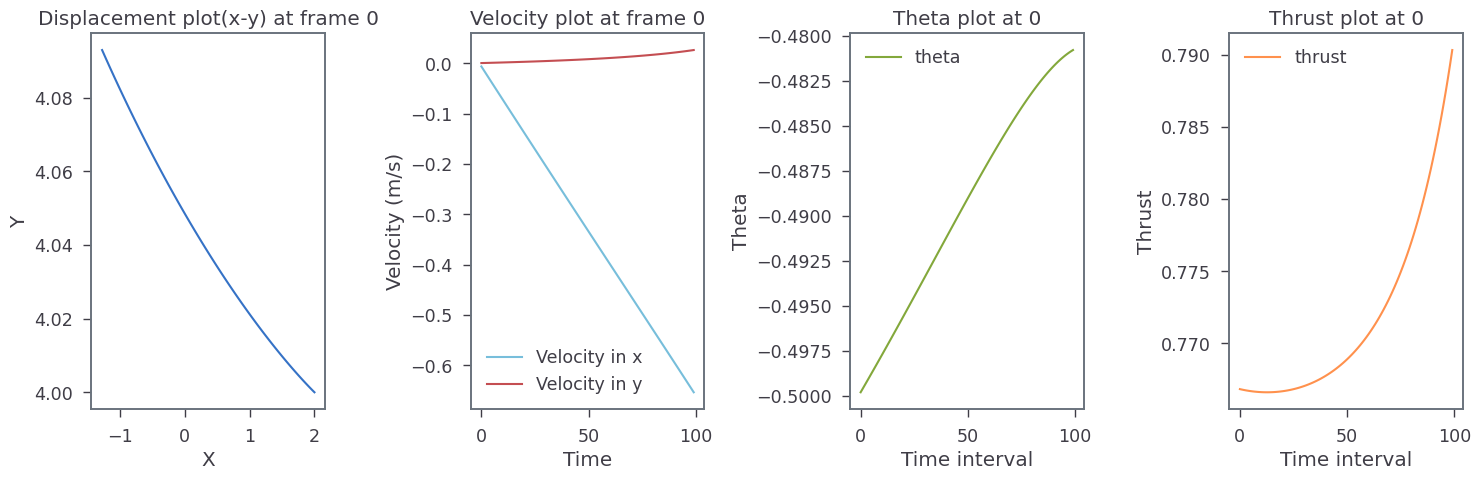

[2] loss: 1.878


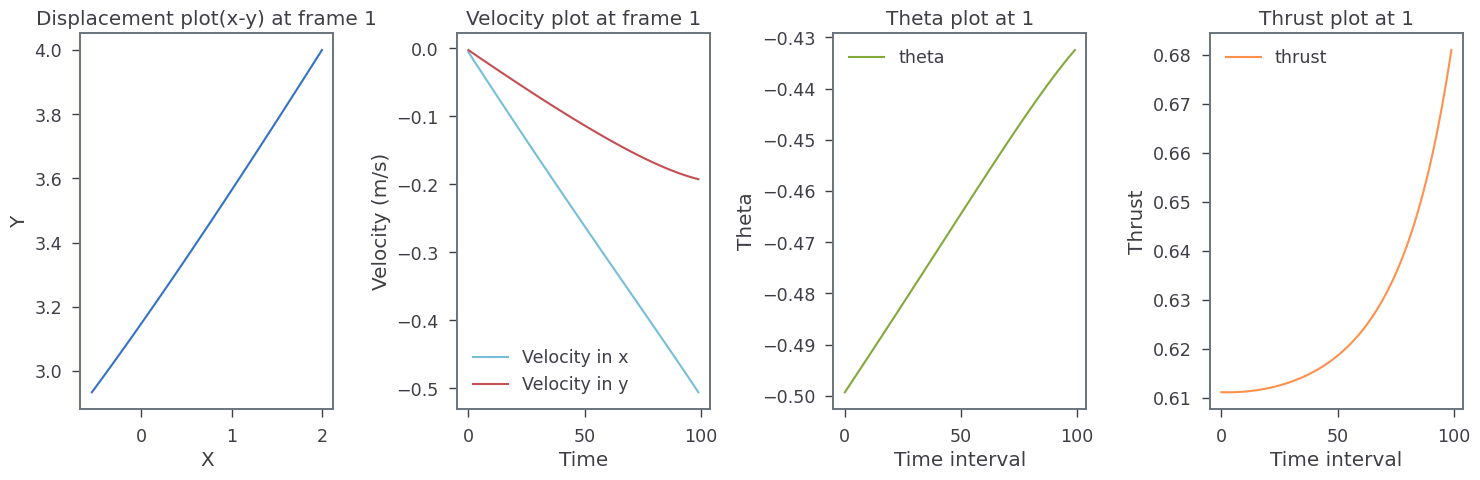

[3] loss: 1.109


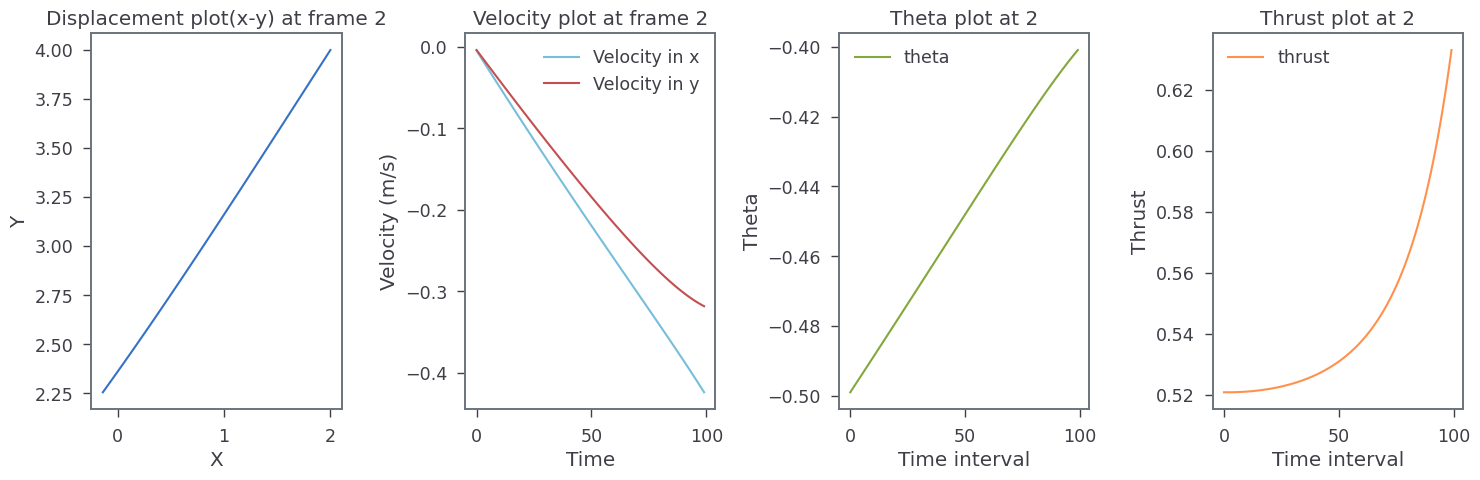

[4] loss: 0.728


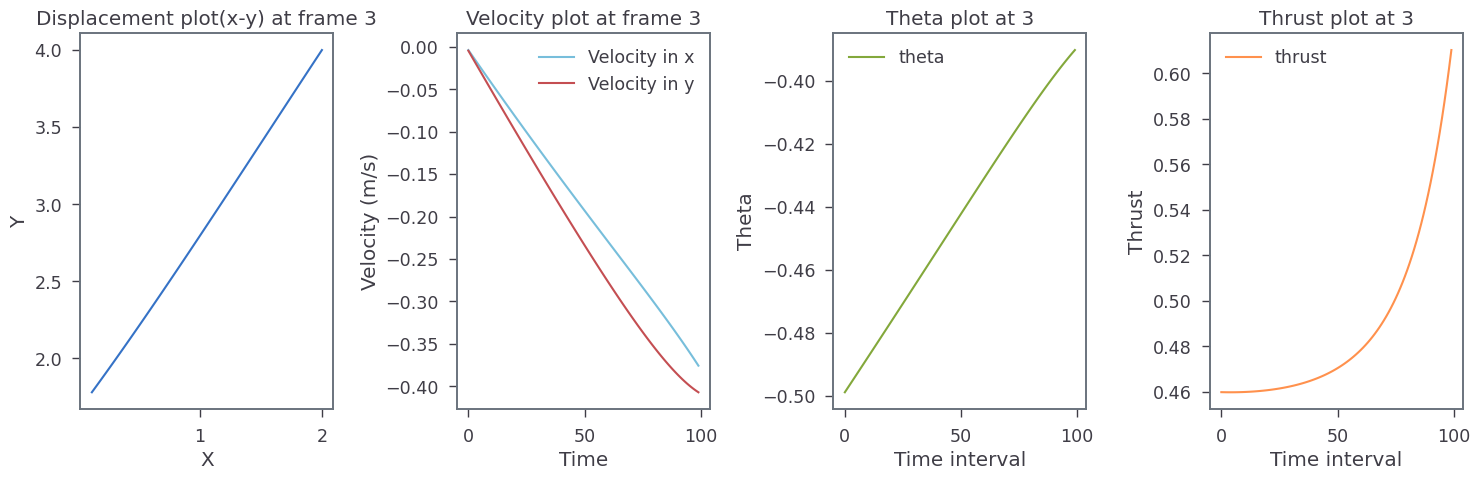

[5] loss: 0.505


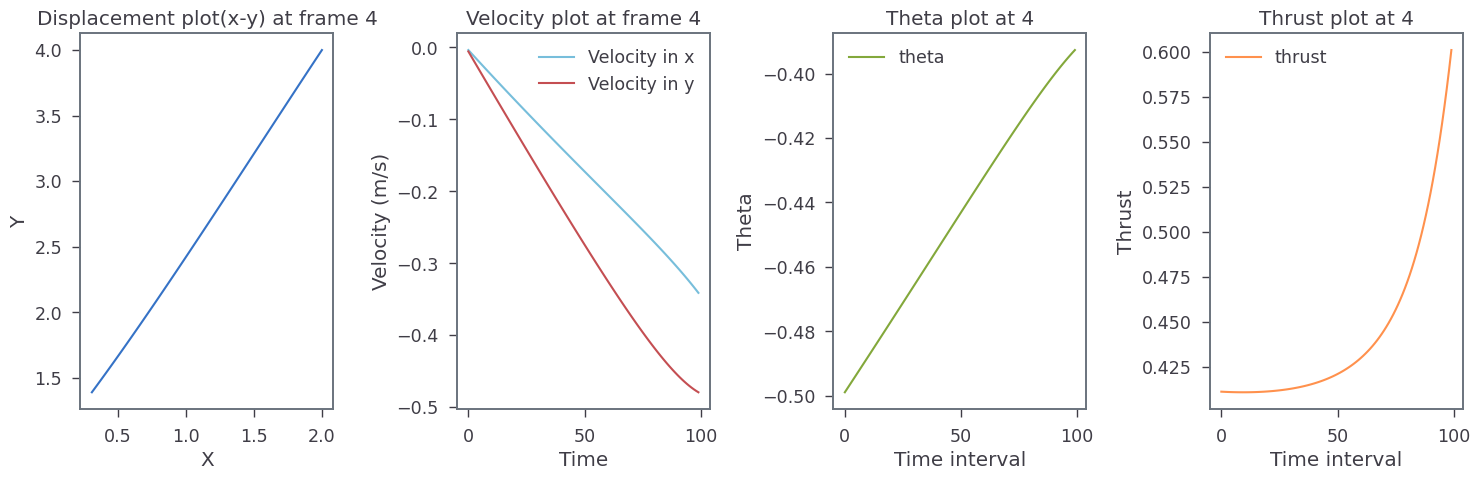

[6] loss: 0.401


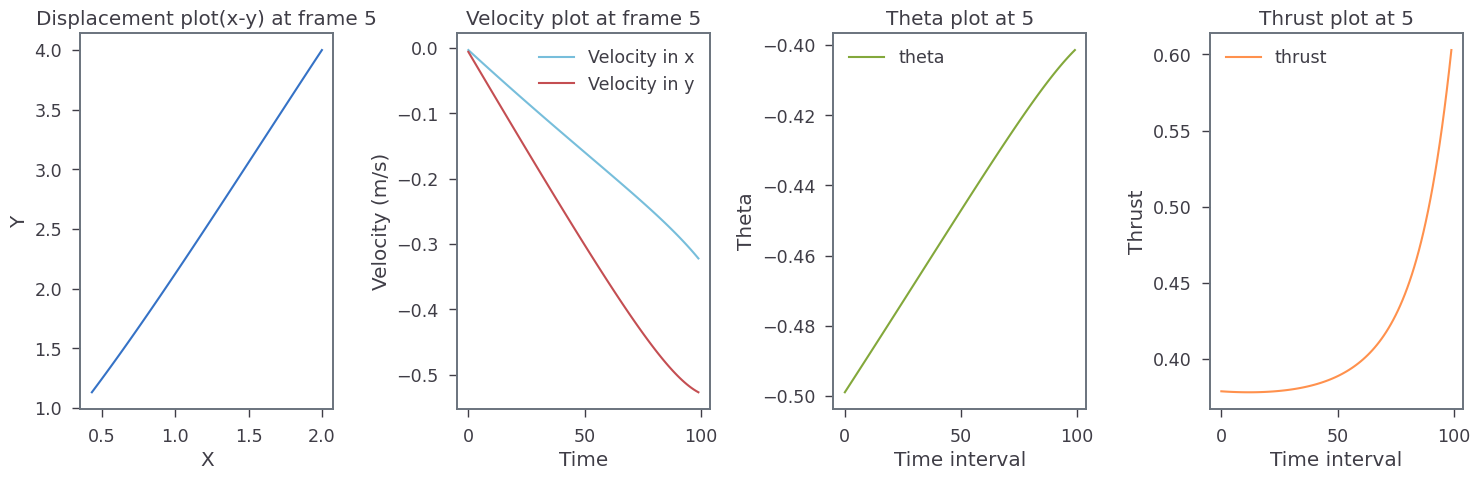

[7] loss: 0.352


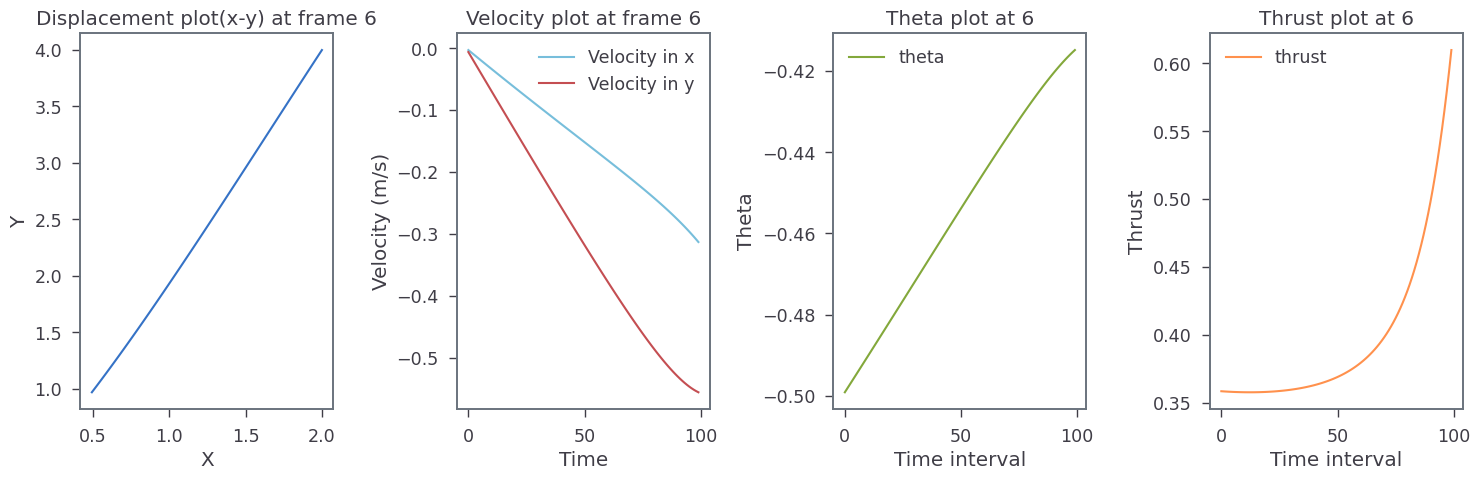

[8] loss: 0.325


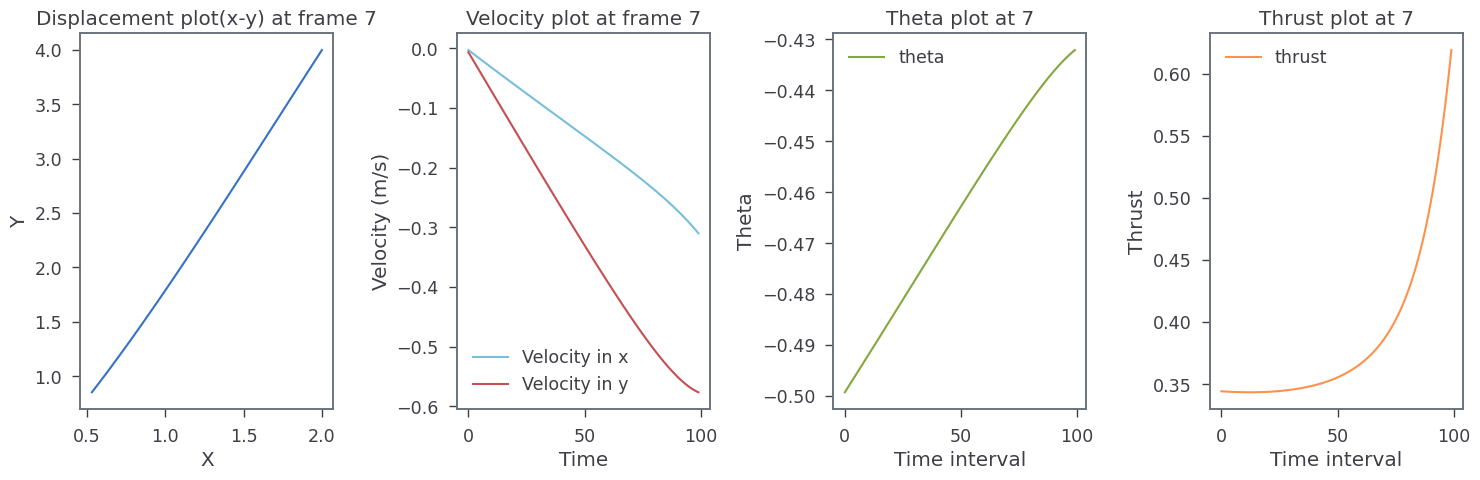

[9] loss: 0.308


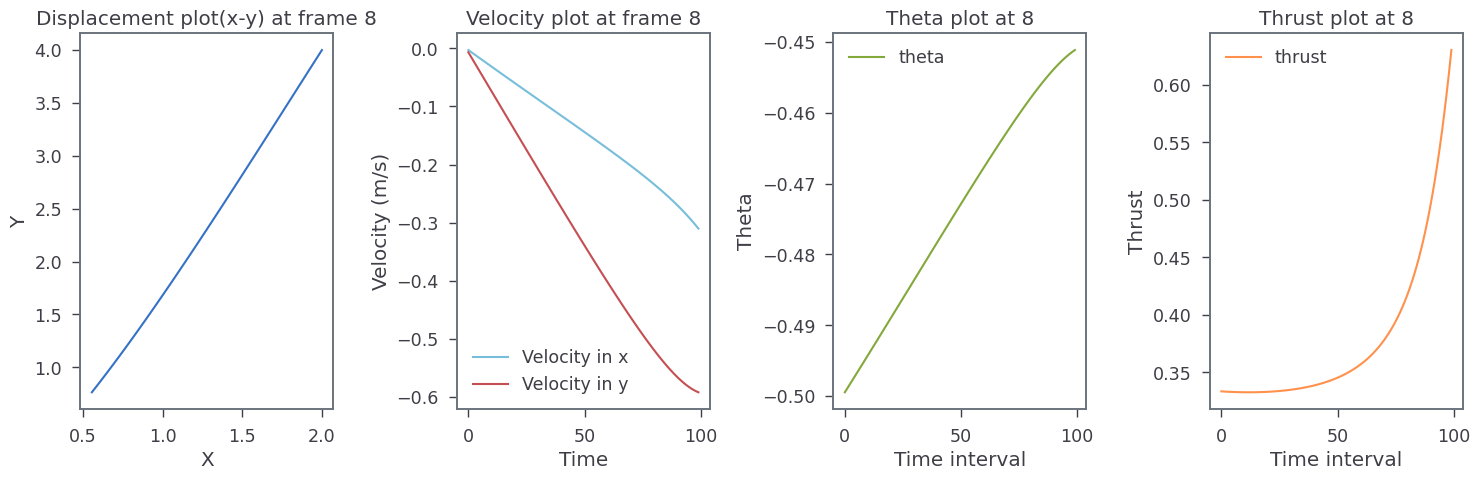

[10] loss: 0.297


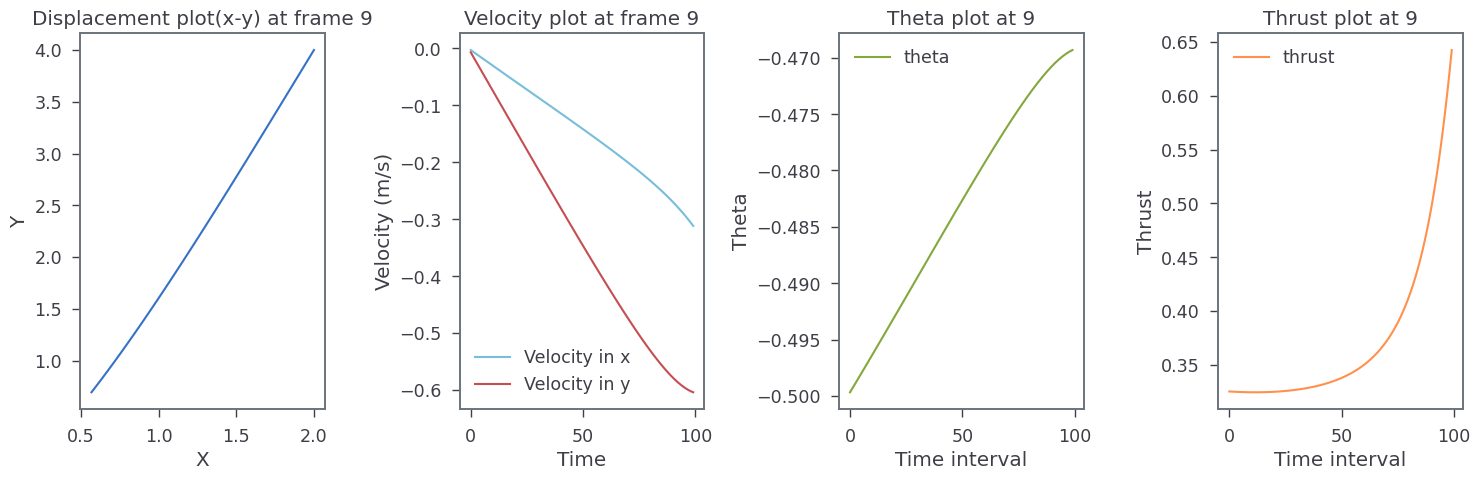

[11] loss: 0.290


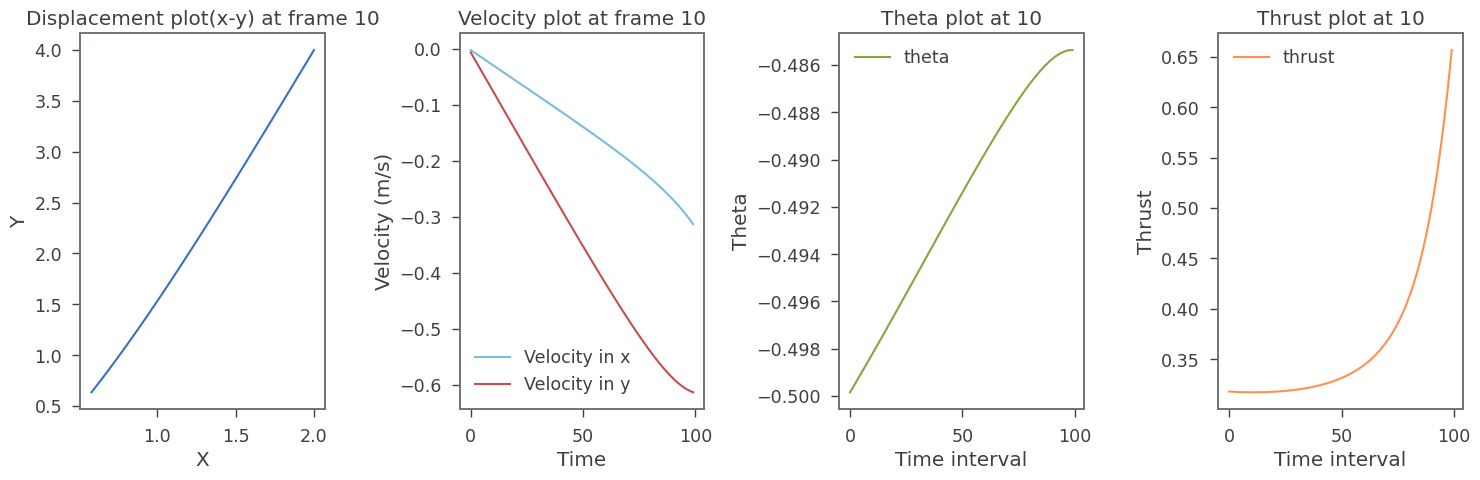

[12] loss: 0.285


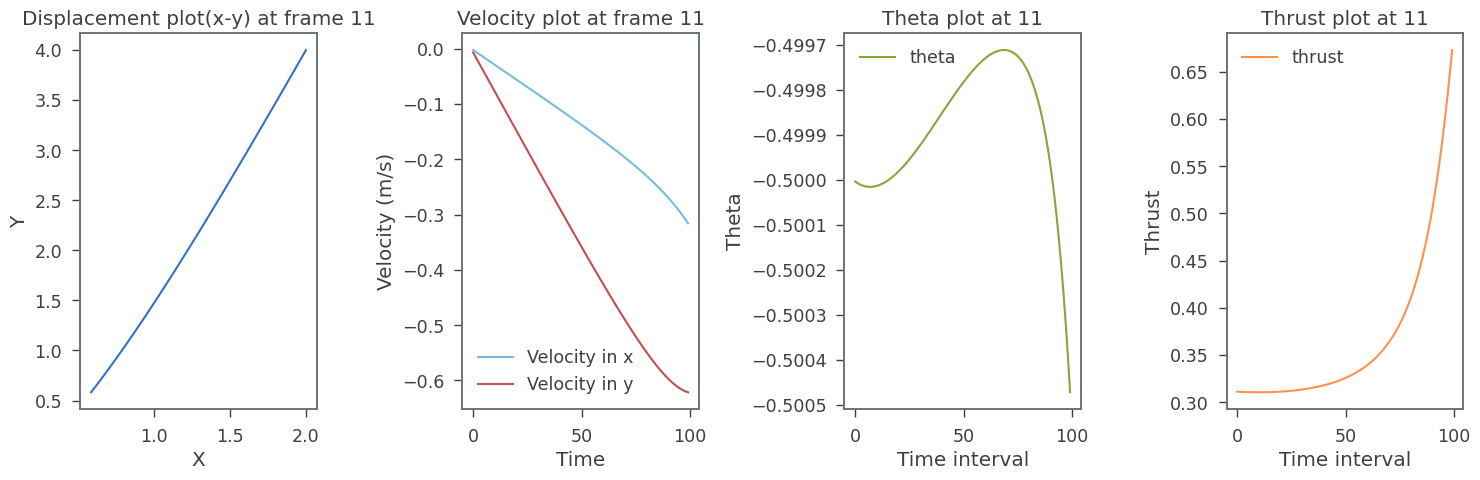

[13] loss: 0.281


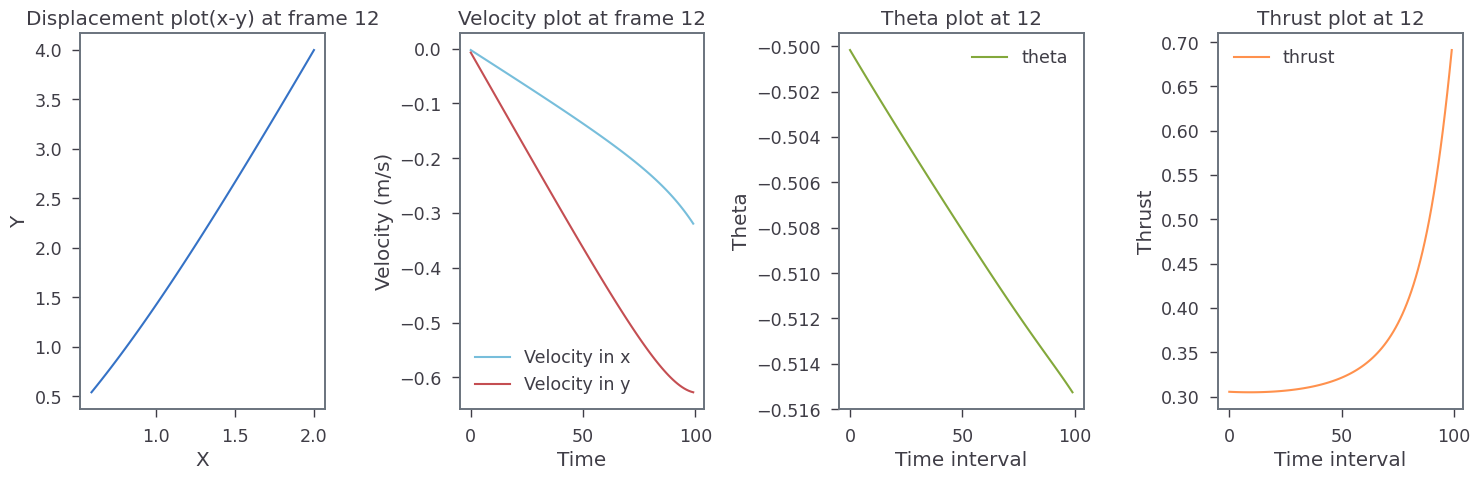

[14] loss: 0.278


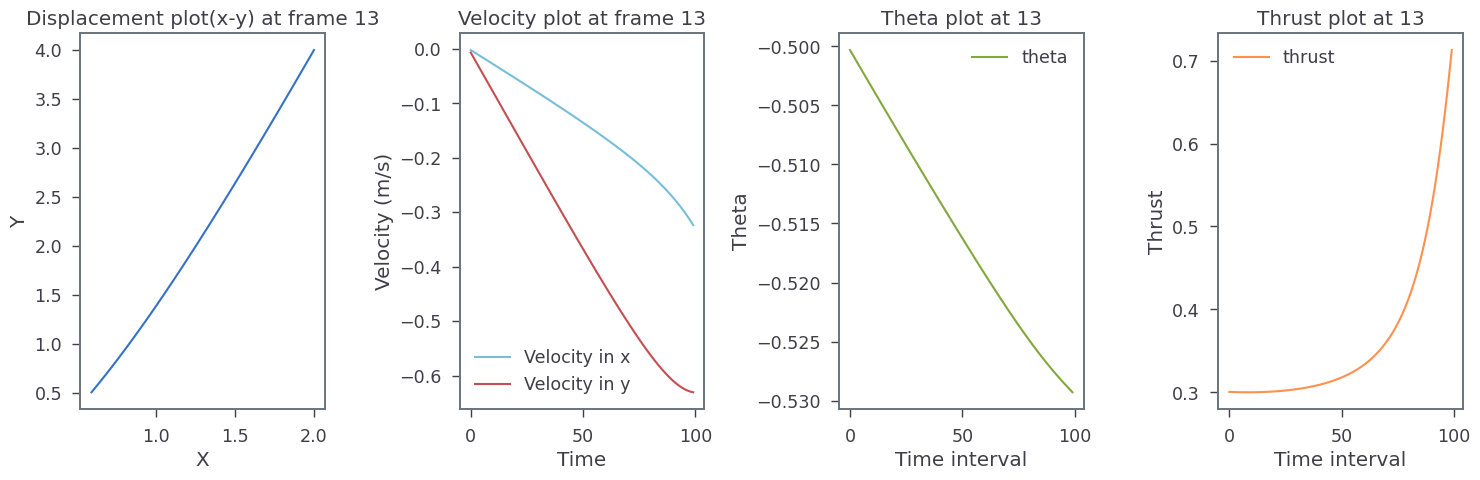

[15] loss: 0.276


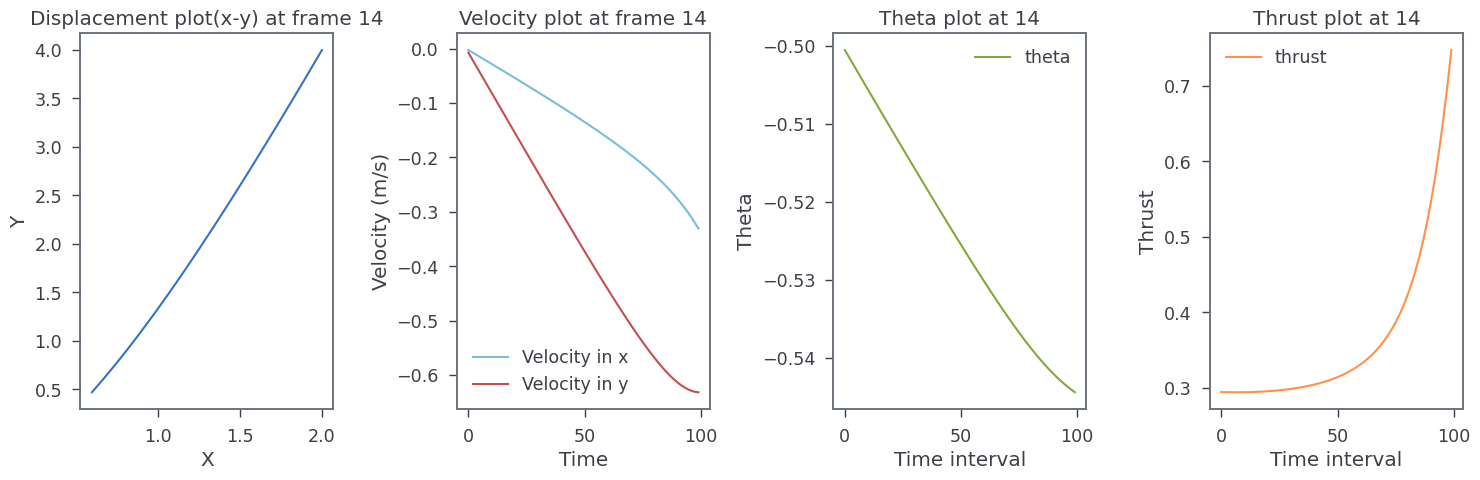

[16] loss: 11.909


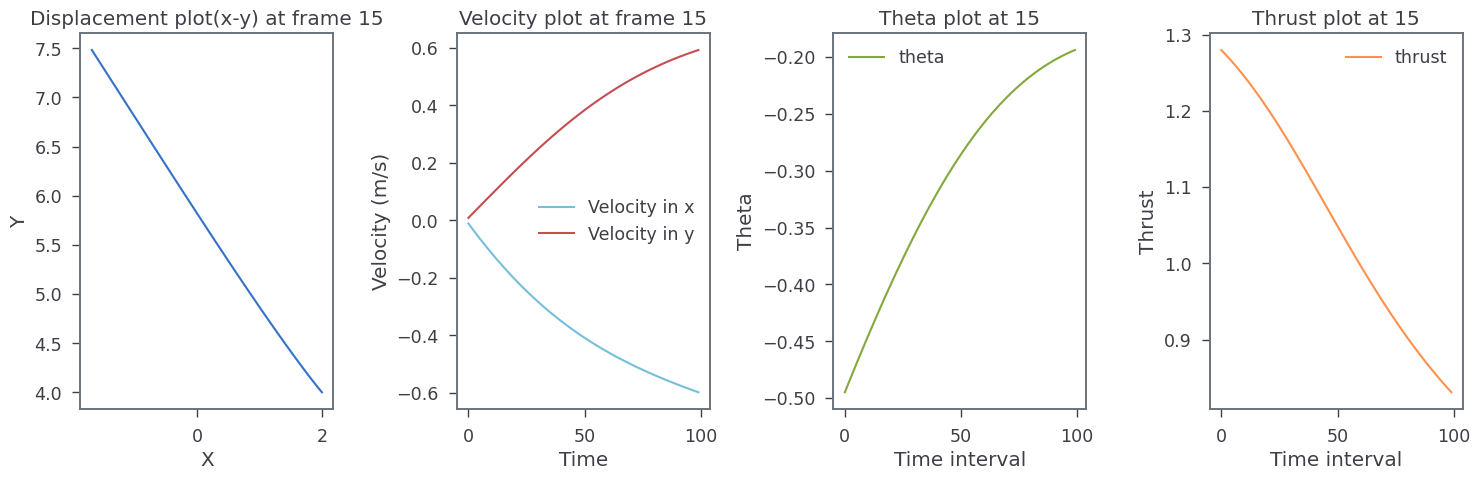

[17] loss: 10.275


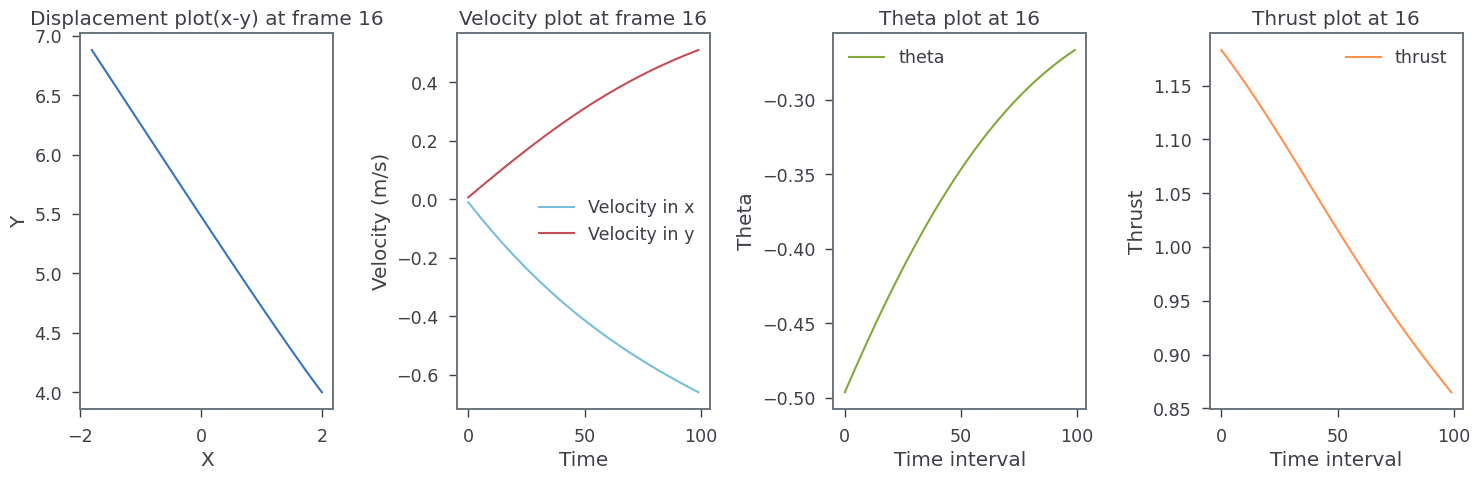

[18] loss: 1.570


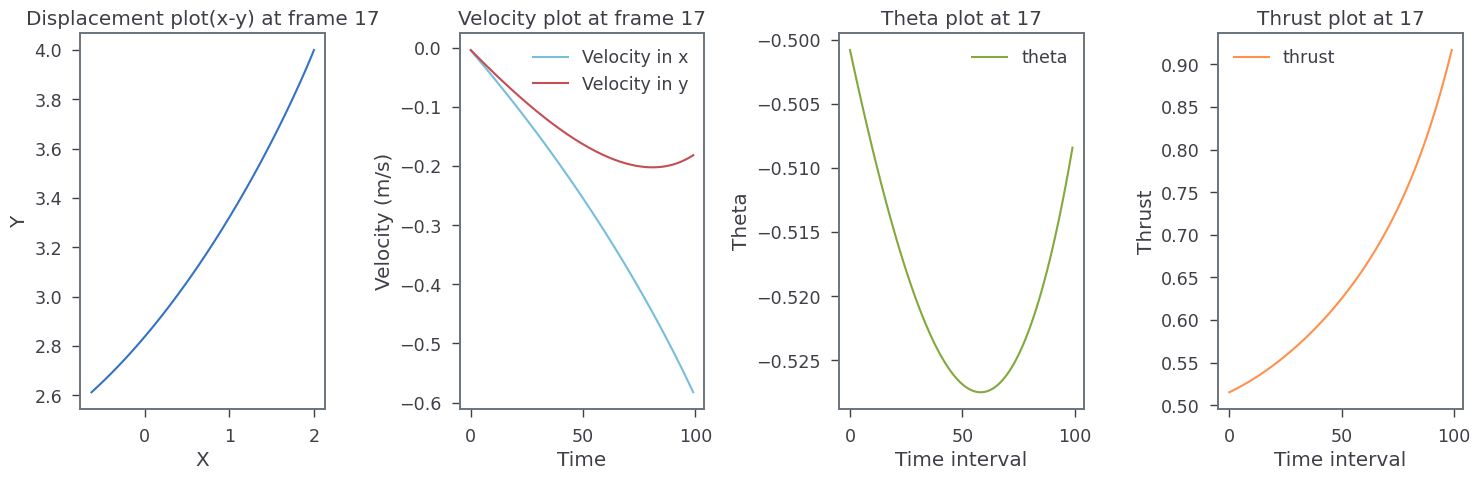

[19] loss: 1.026


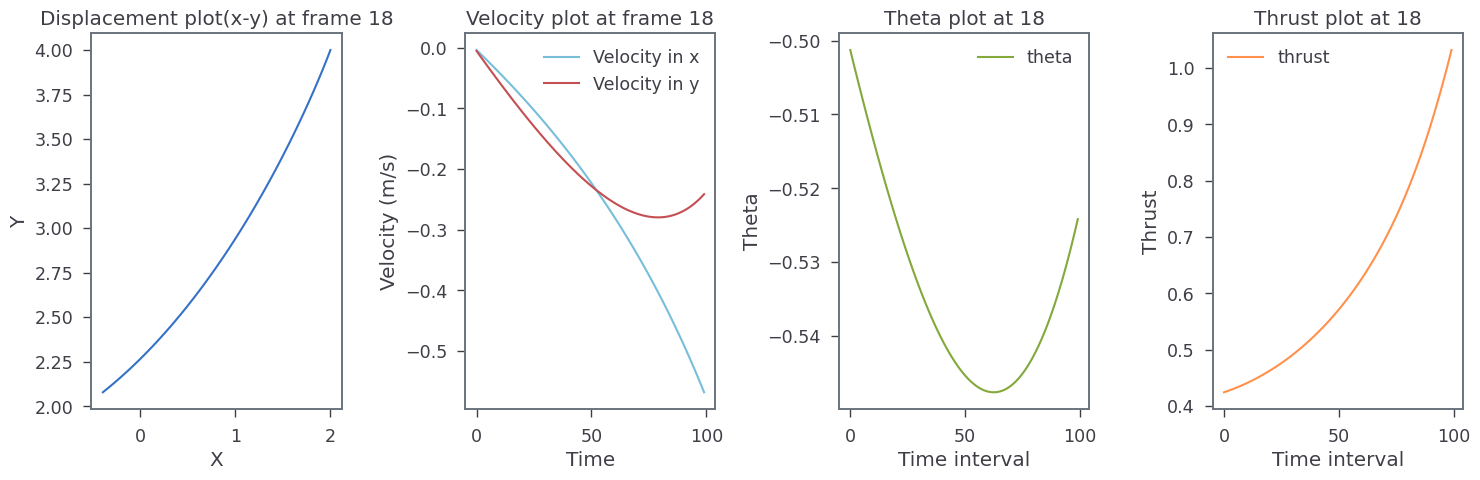

[20] loss: 0.762


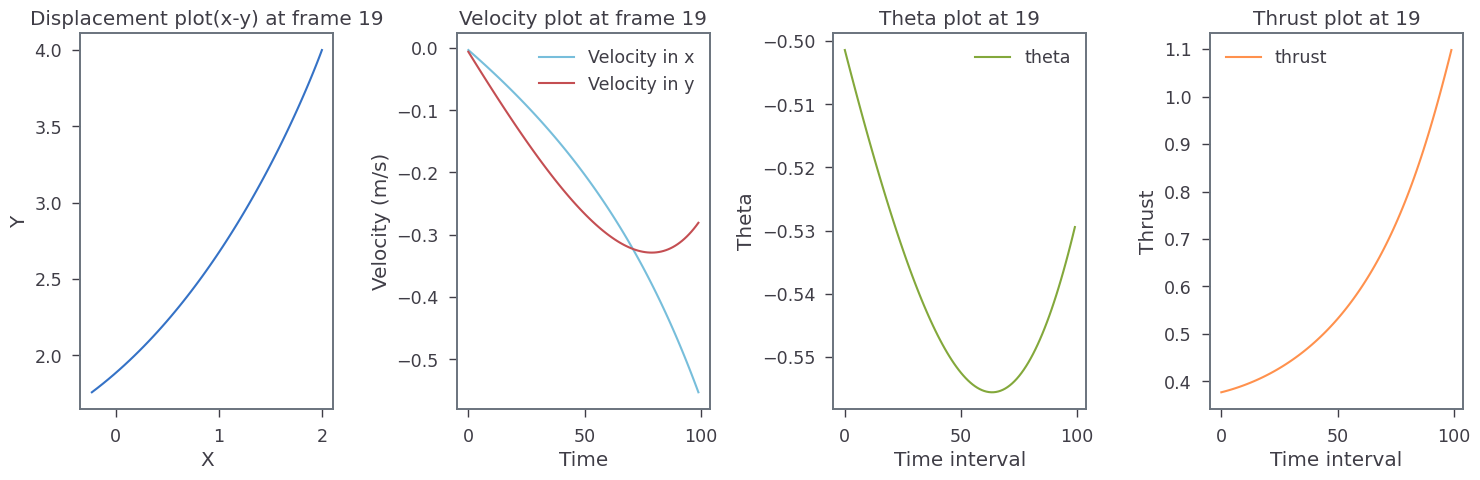

[21] loss: 0.593


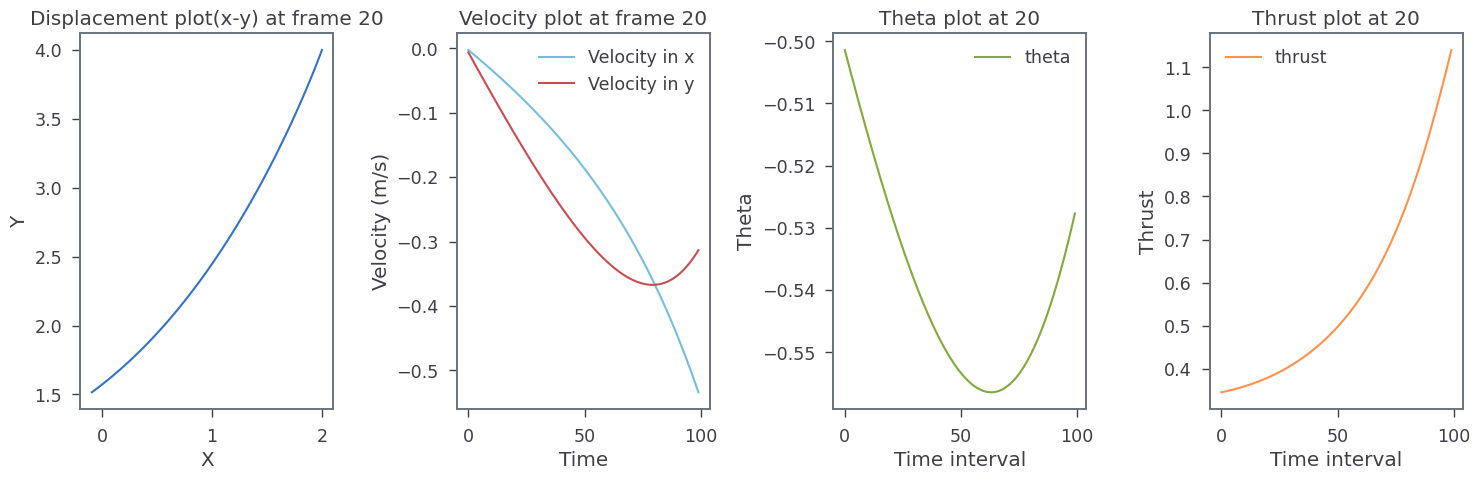

[22] loss: 0.477


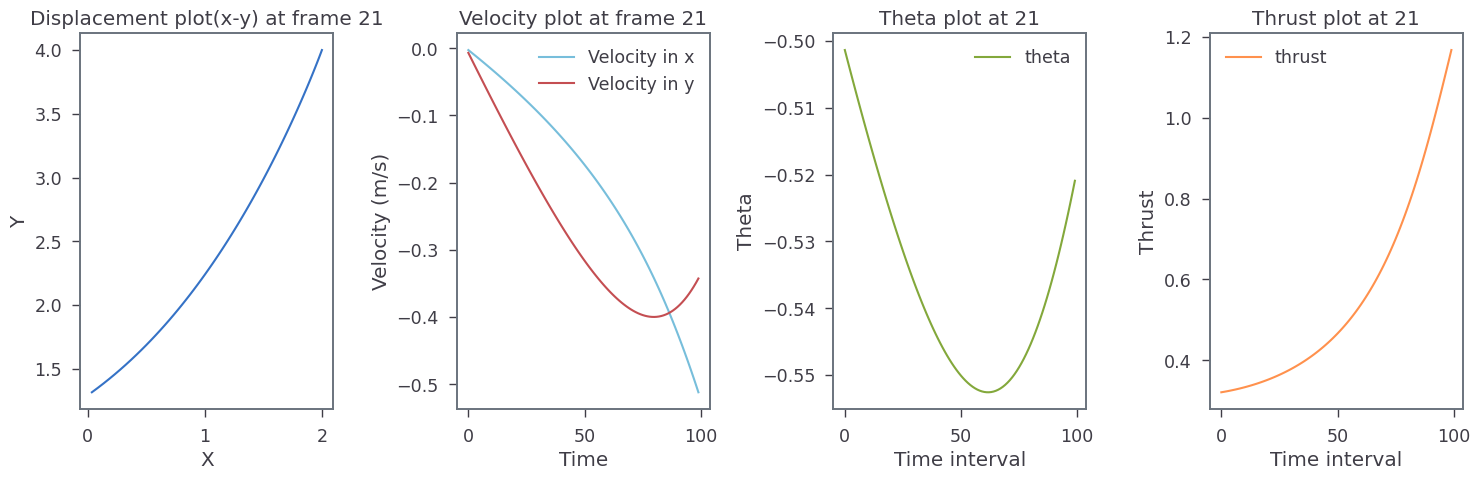

[23] loss: 0.391


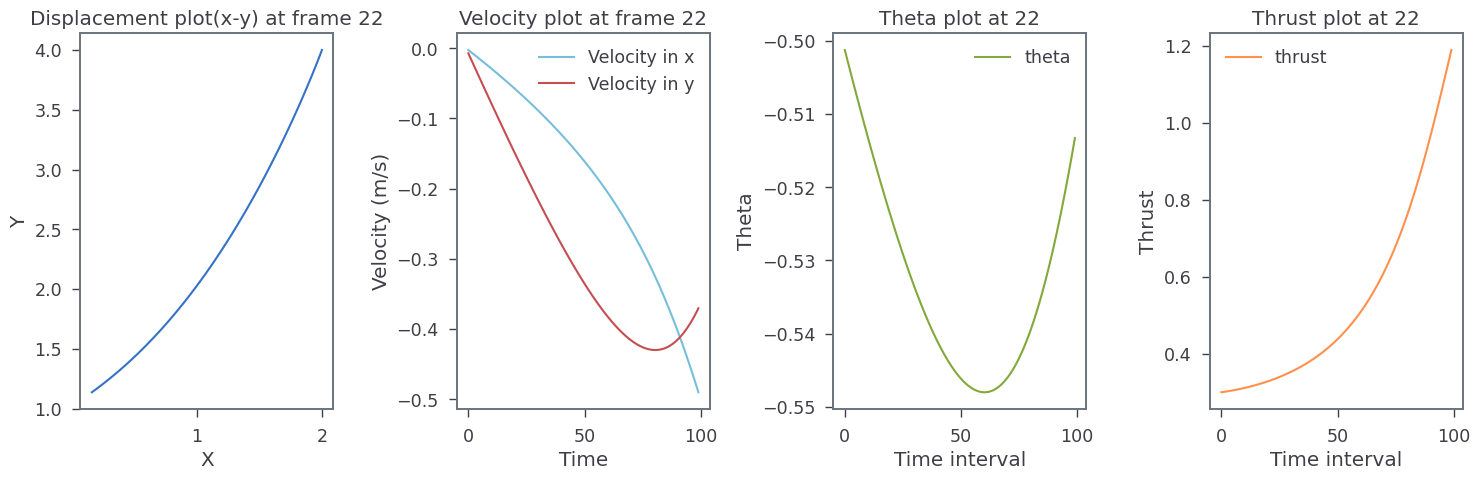

[24] loss: 0.324


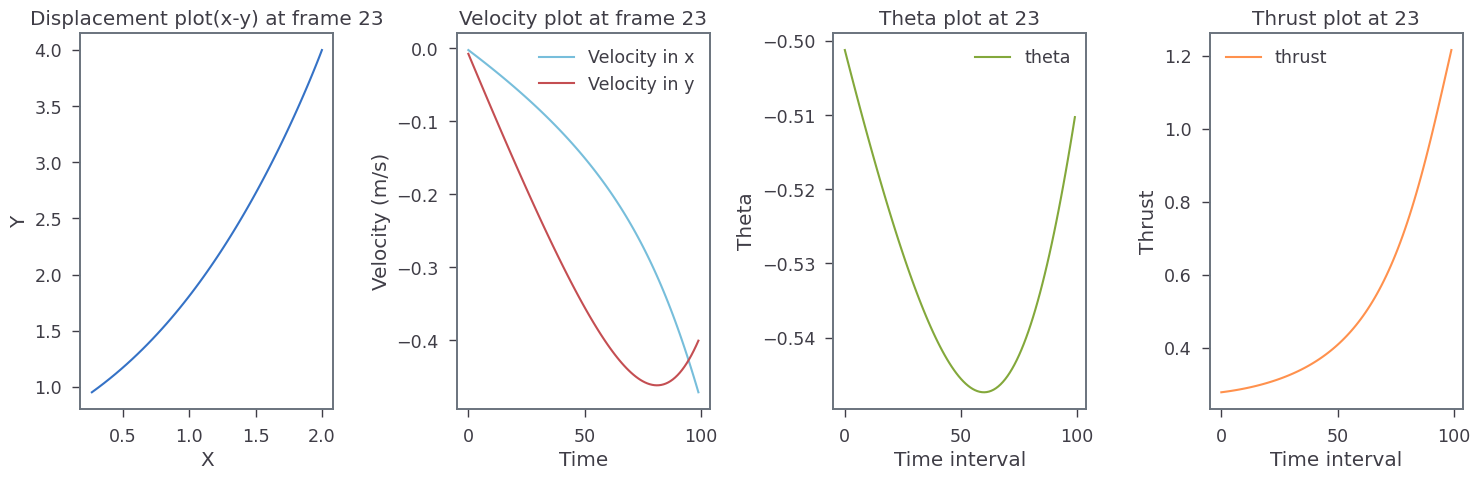

[25] loss: 0.283


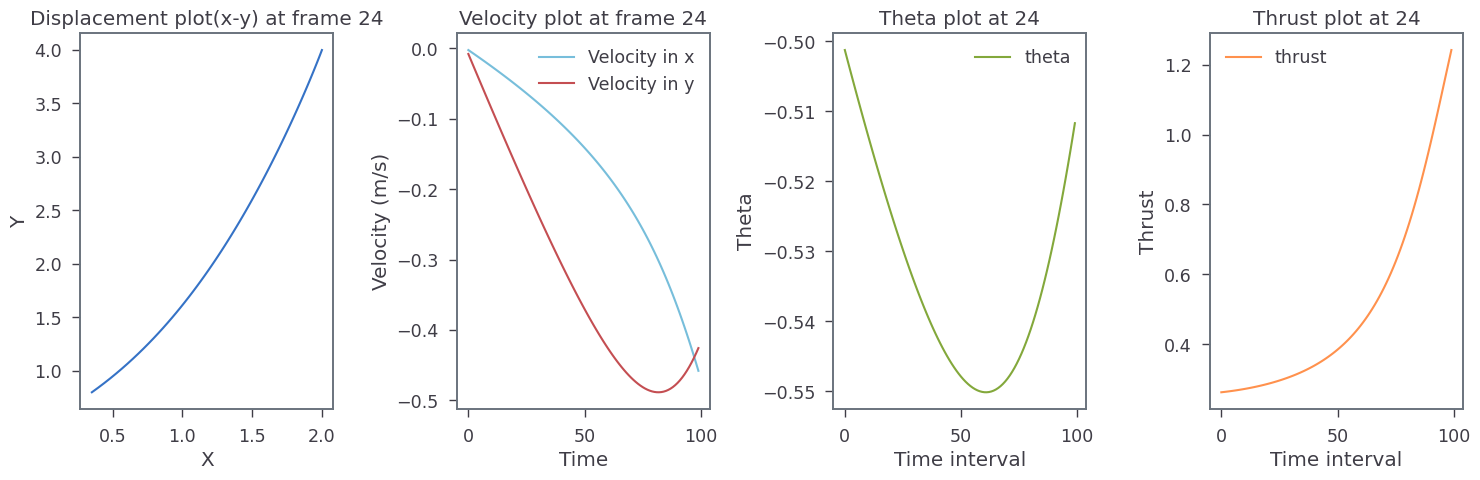

[26] loss: 0.260


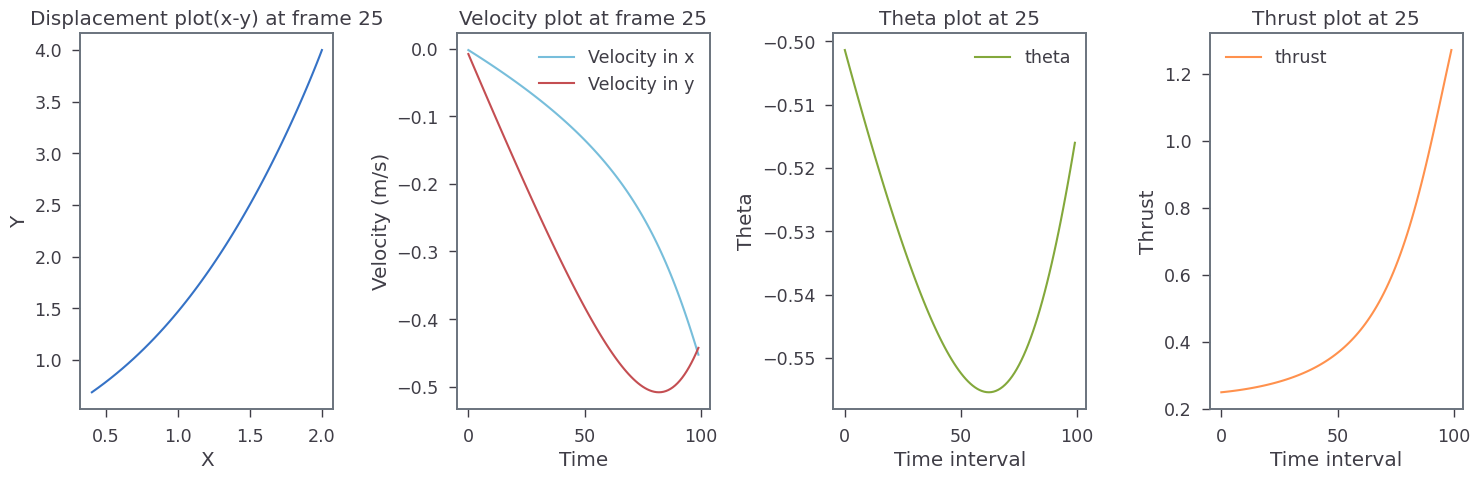

[27] loss: 0.247


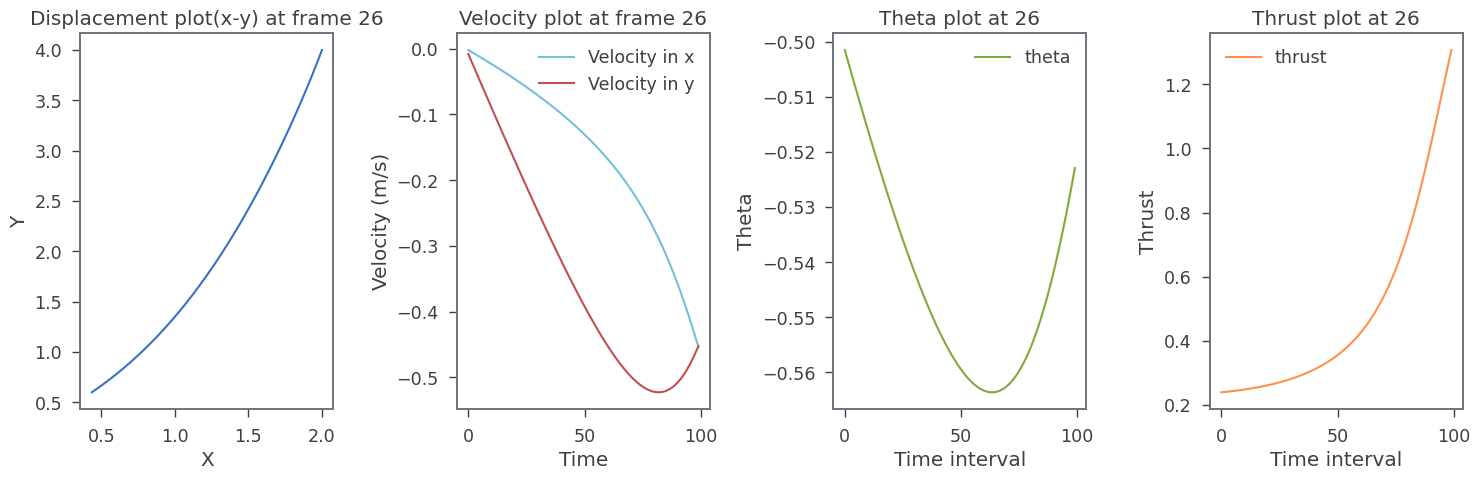

[28] loss: 0.238


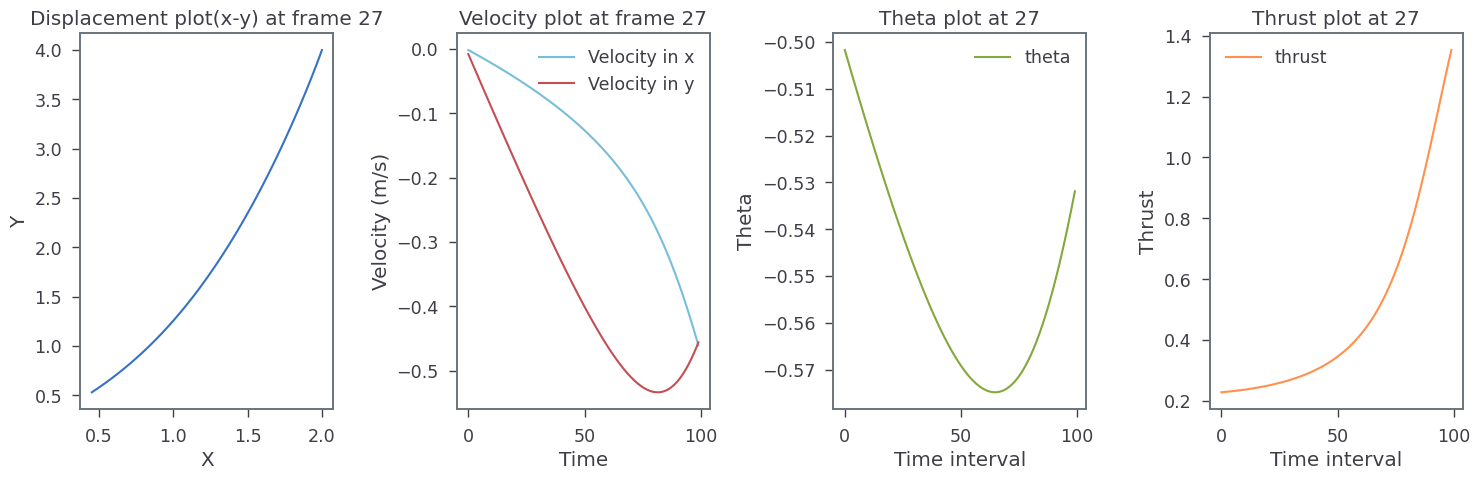

[29] loss: 0.230


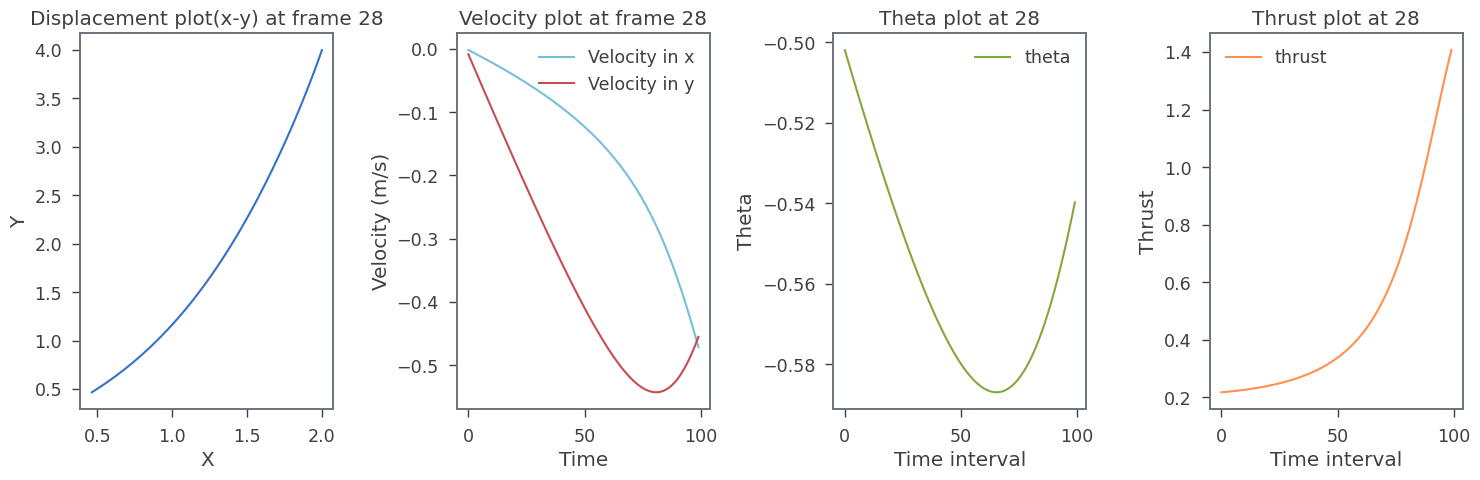

[30] loss: 0.222


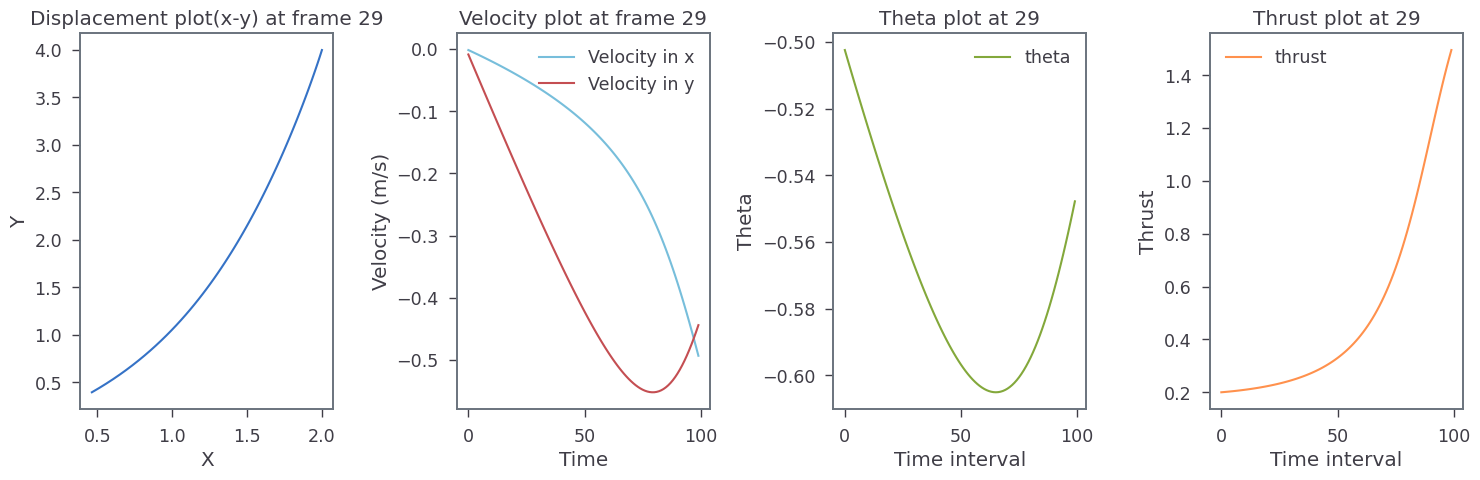

[31] loss: 0.213


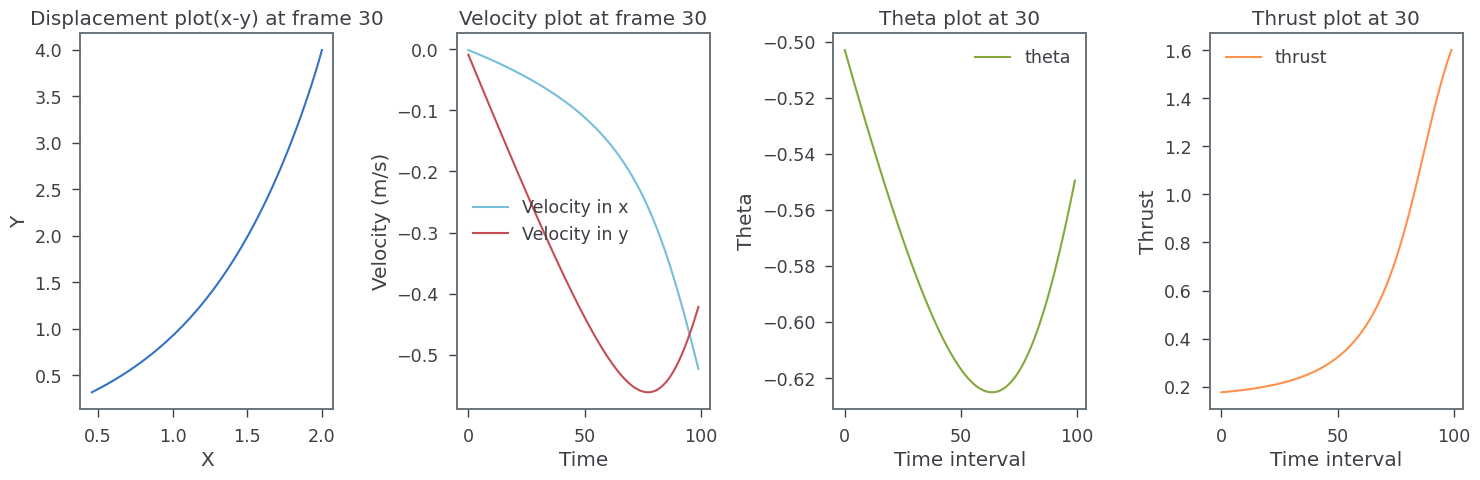

[32] loss: 0.183


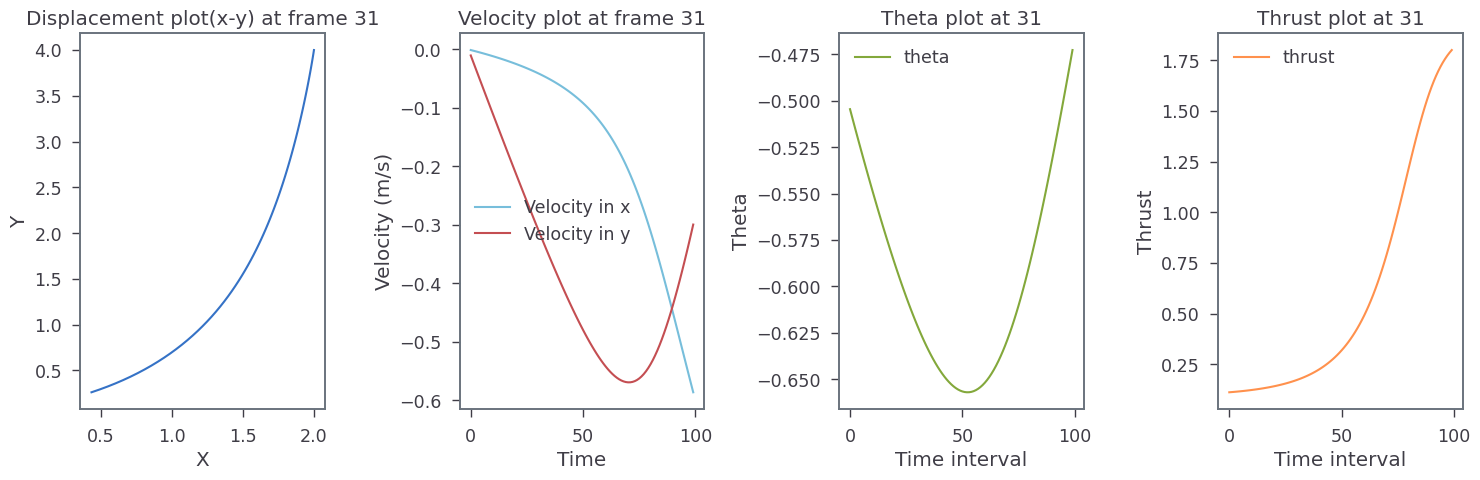

[33] loss: 0.159


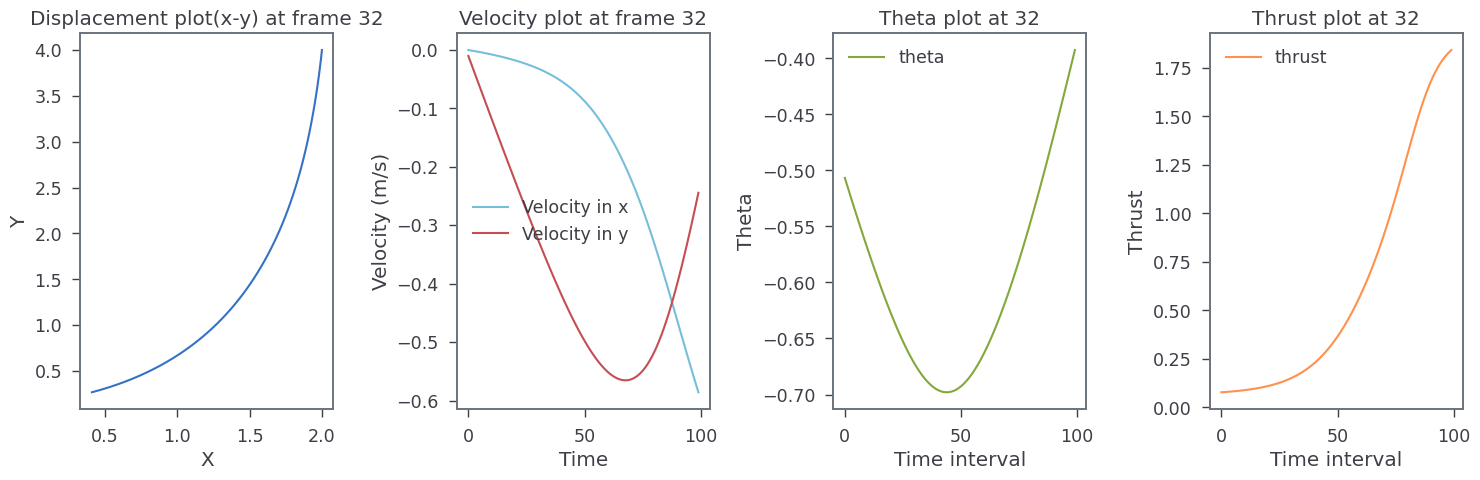

[34] loss: 0.137


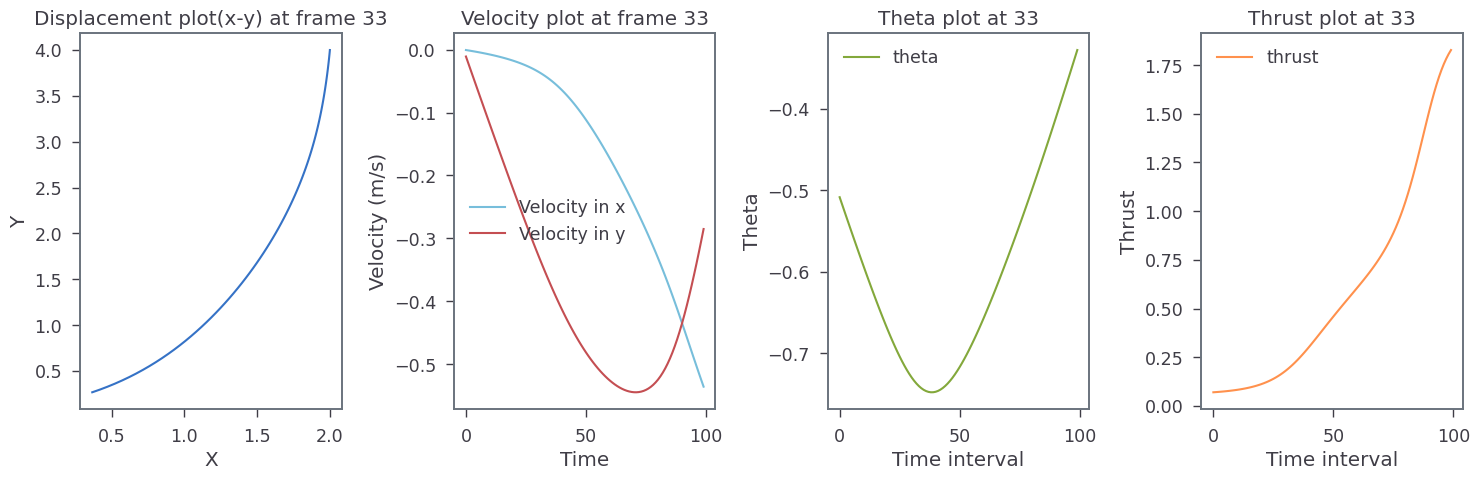

[35] loss: 0.119


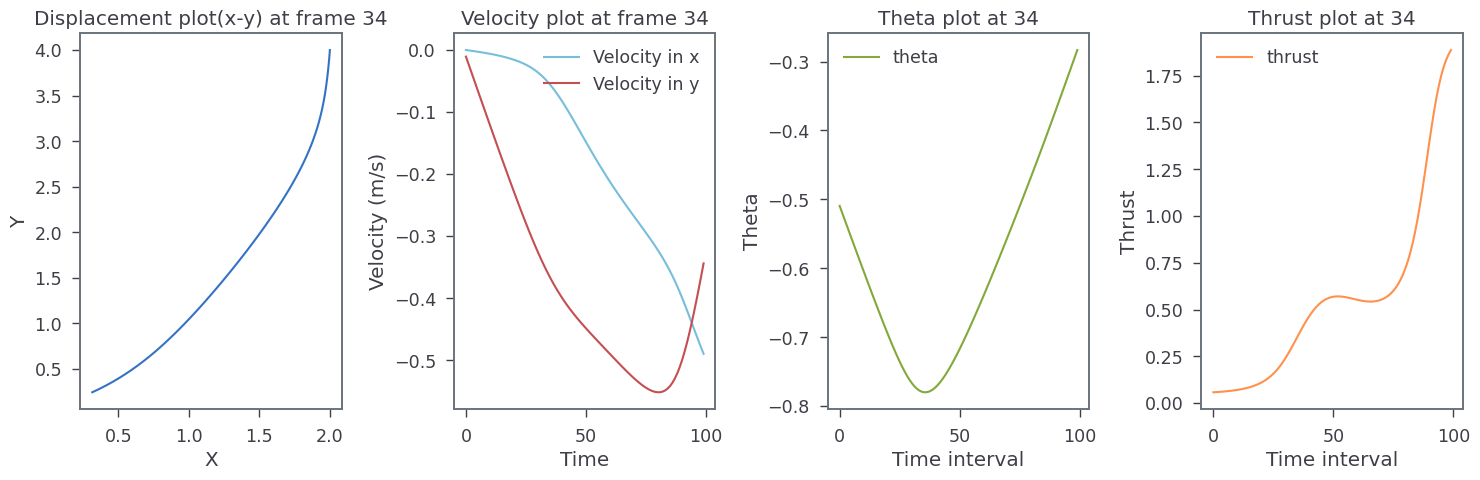

[36] loss: 0.110


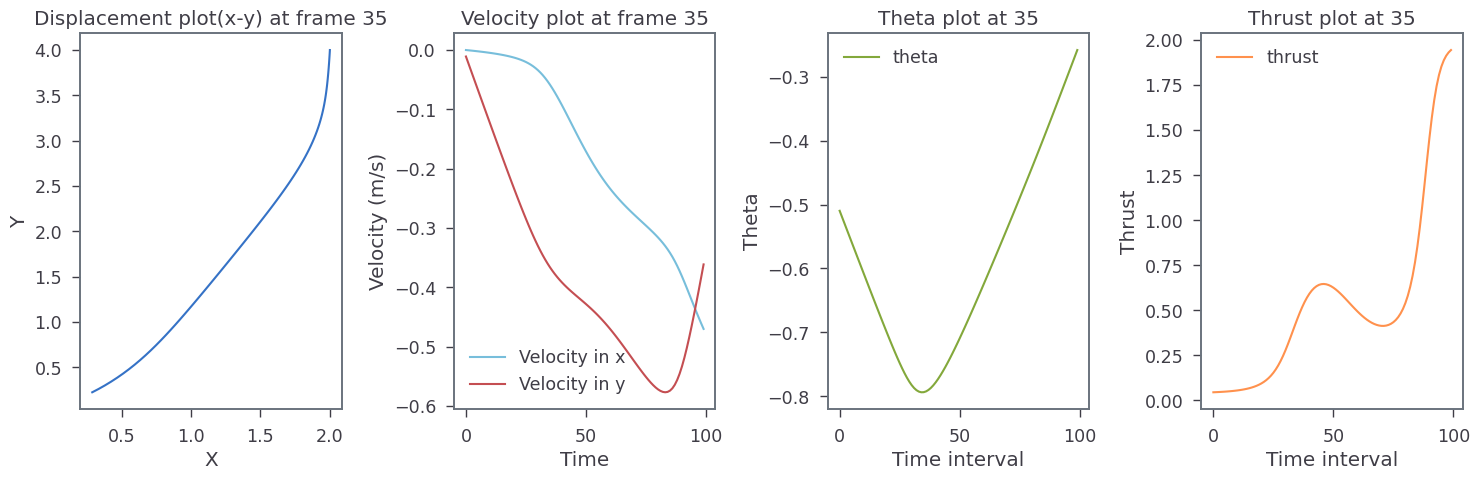

[37] loss: 0.104


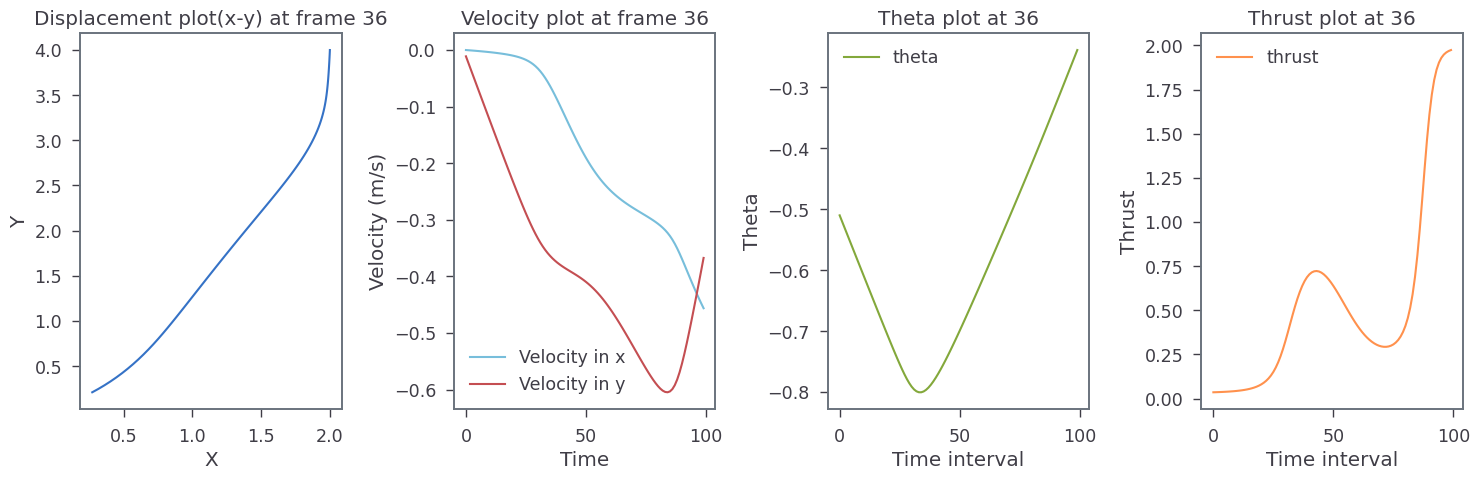

[38] loss: 0.098


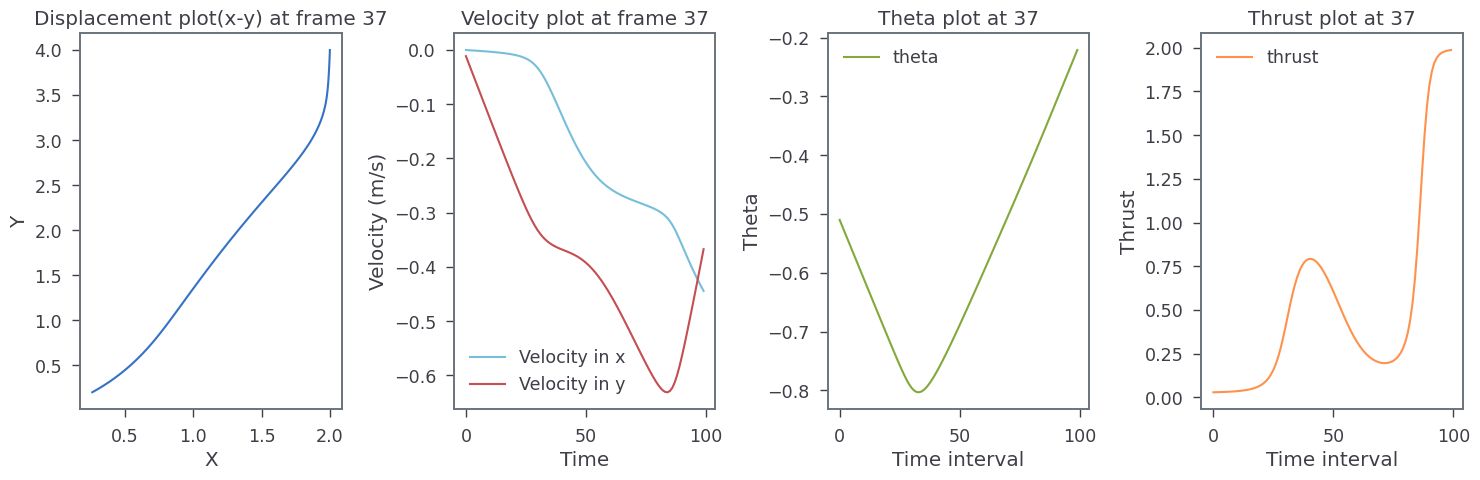

[39] loss: 0.093


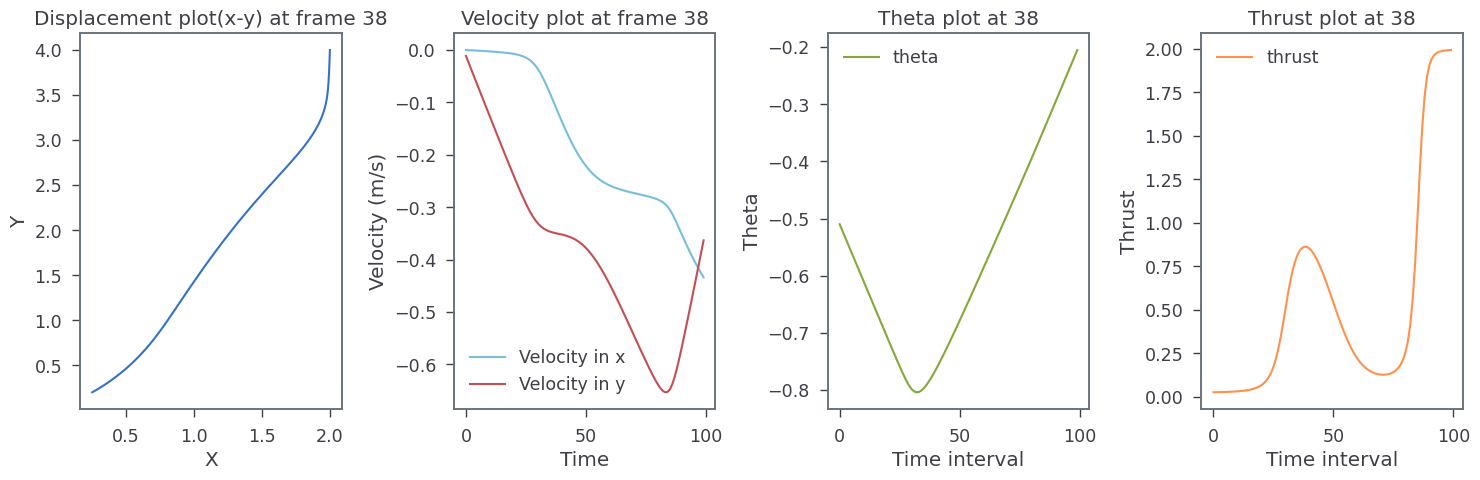

[40] loss: 0.090


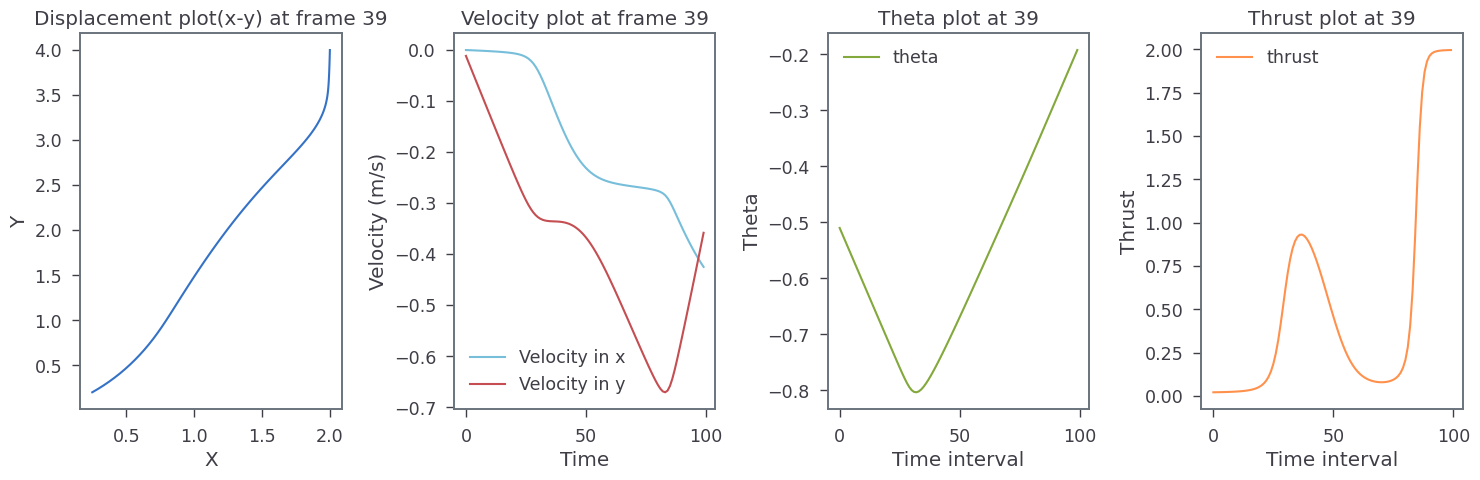

[41] loss: 0.087


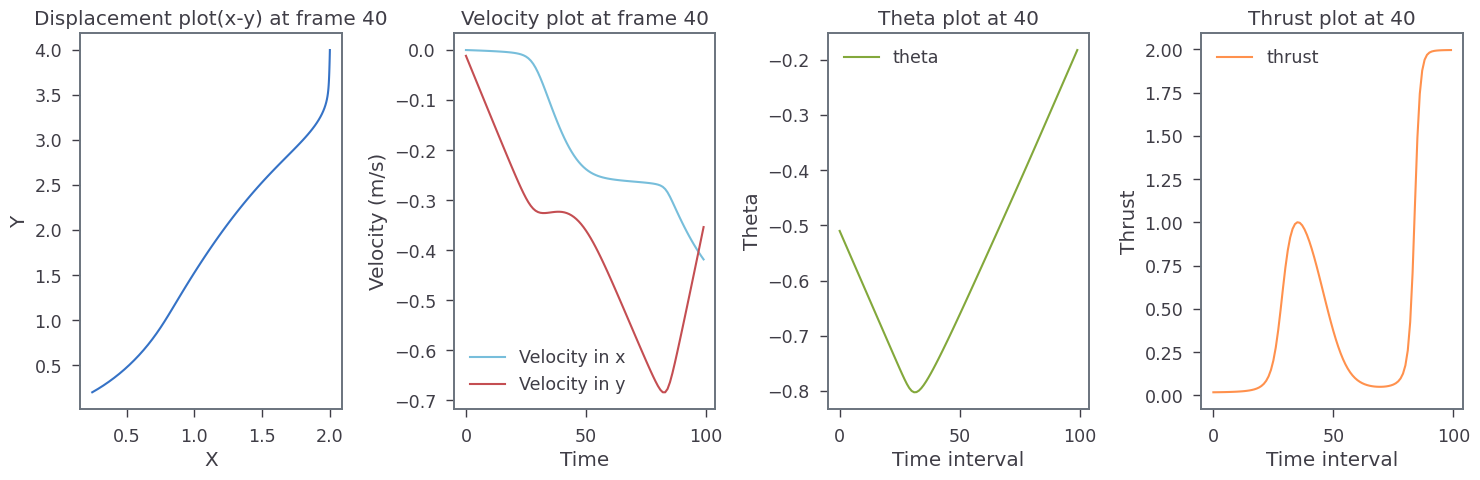

[42] loss: 0.084


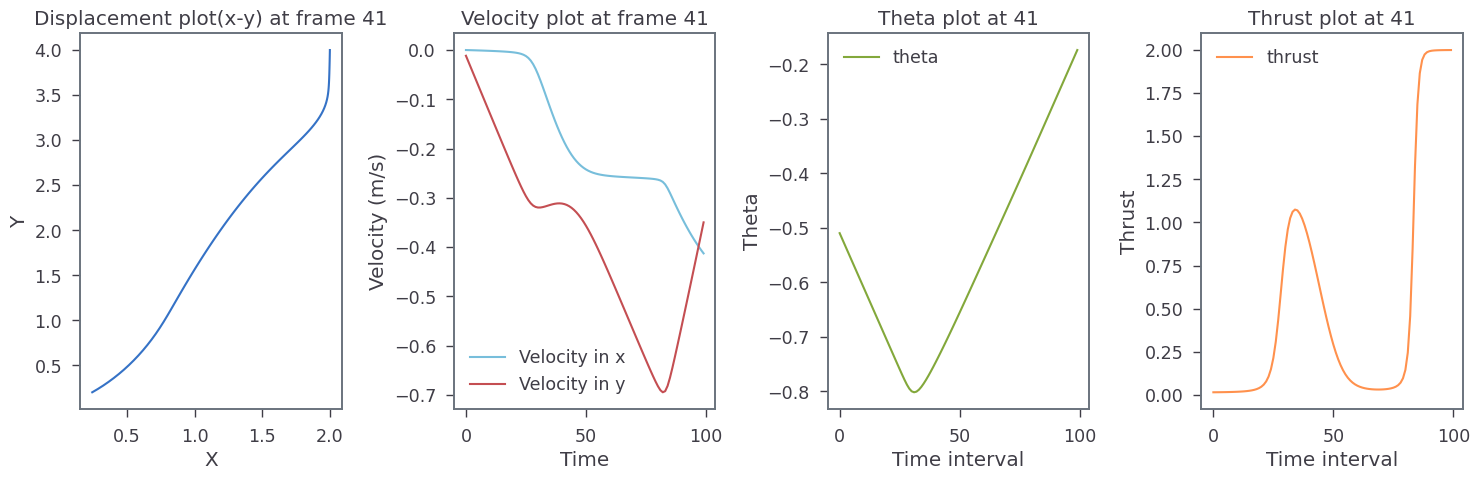

[43] loss: 0.082


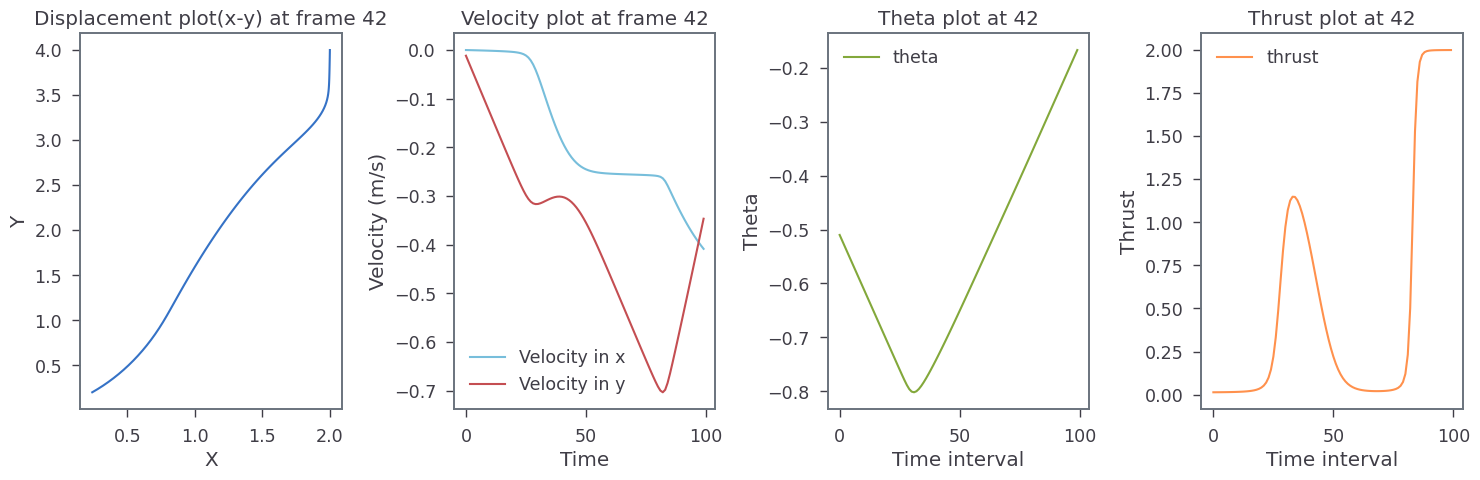

[44] loss: 0.081


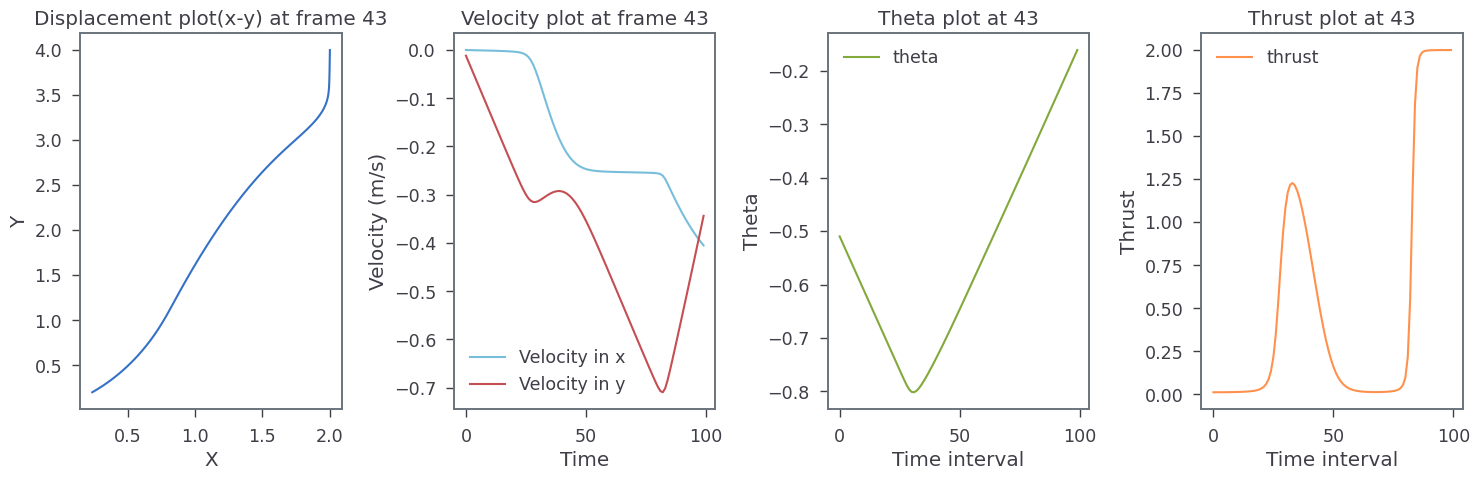

[45] loss: 0.079


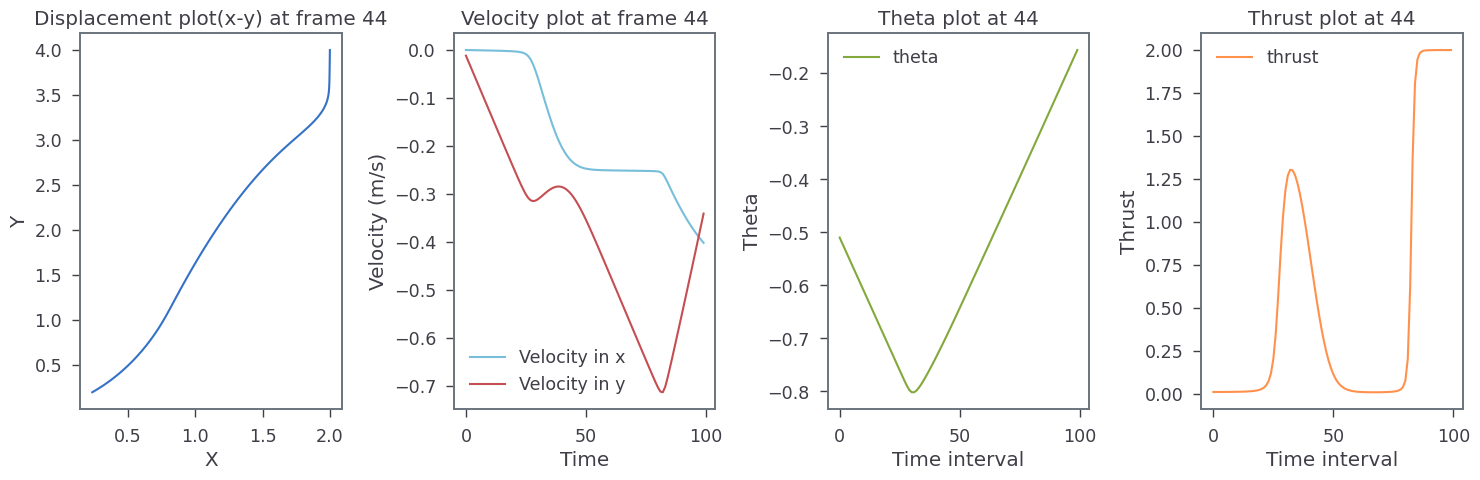

[46] loss: 0.078


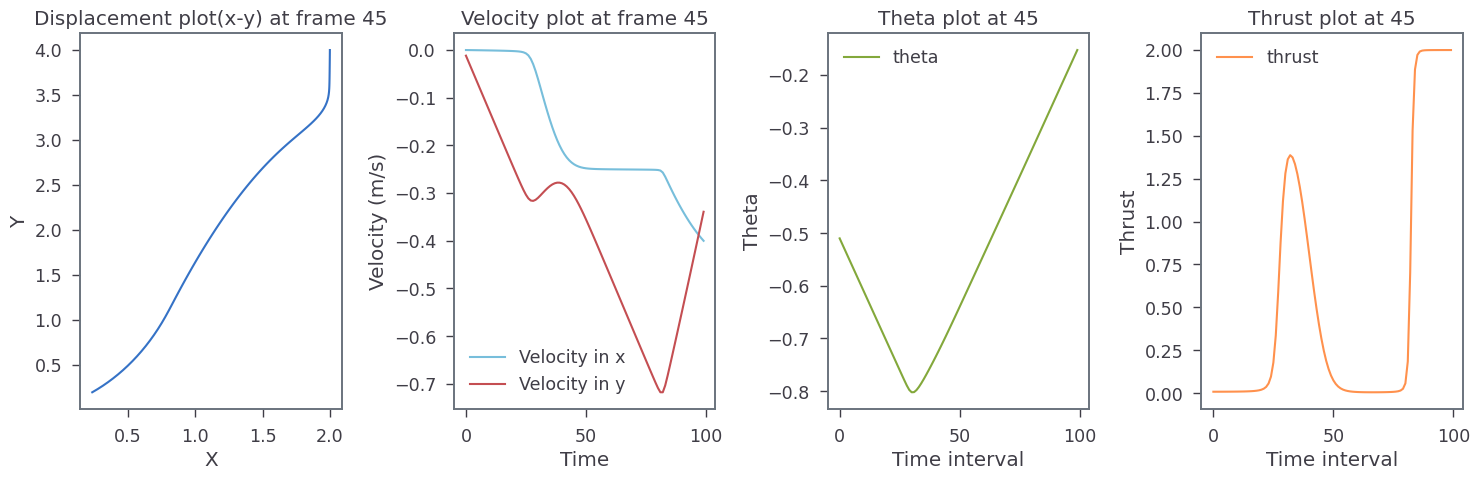

[47] loss: 0.077


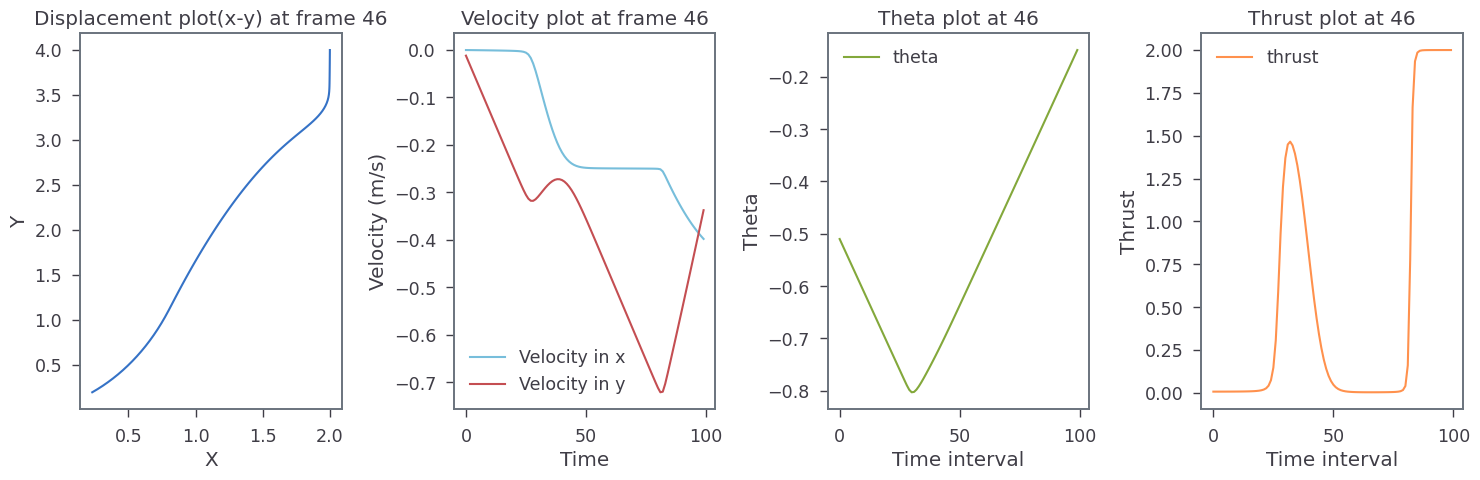

[48] loss: 0.076


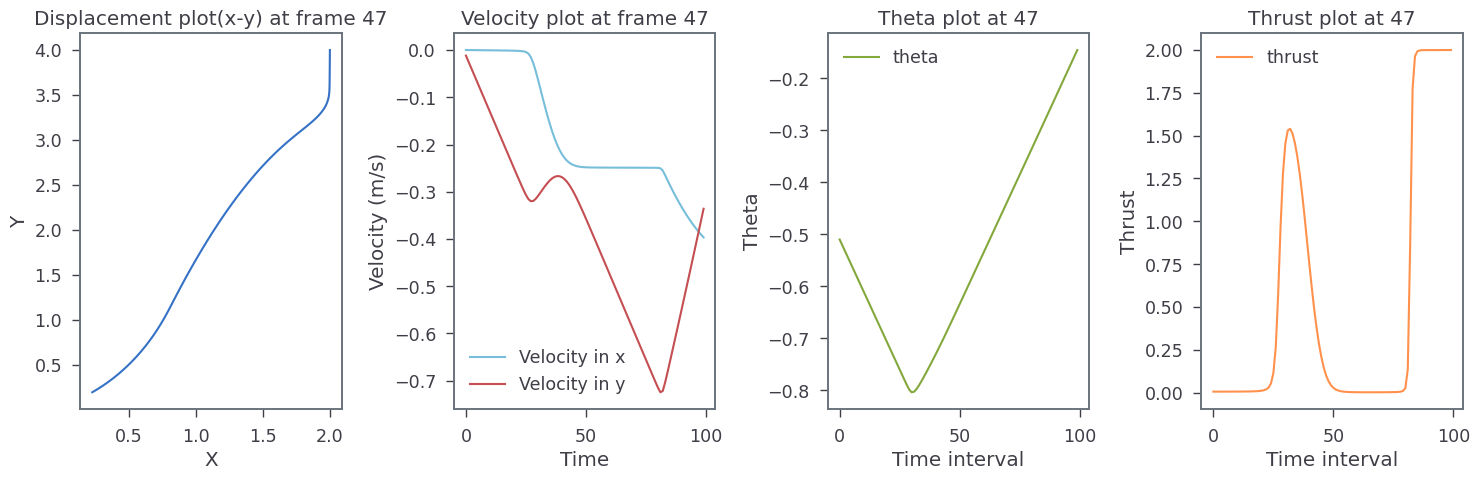

[49] loss: 0.076


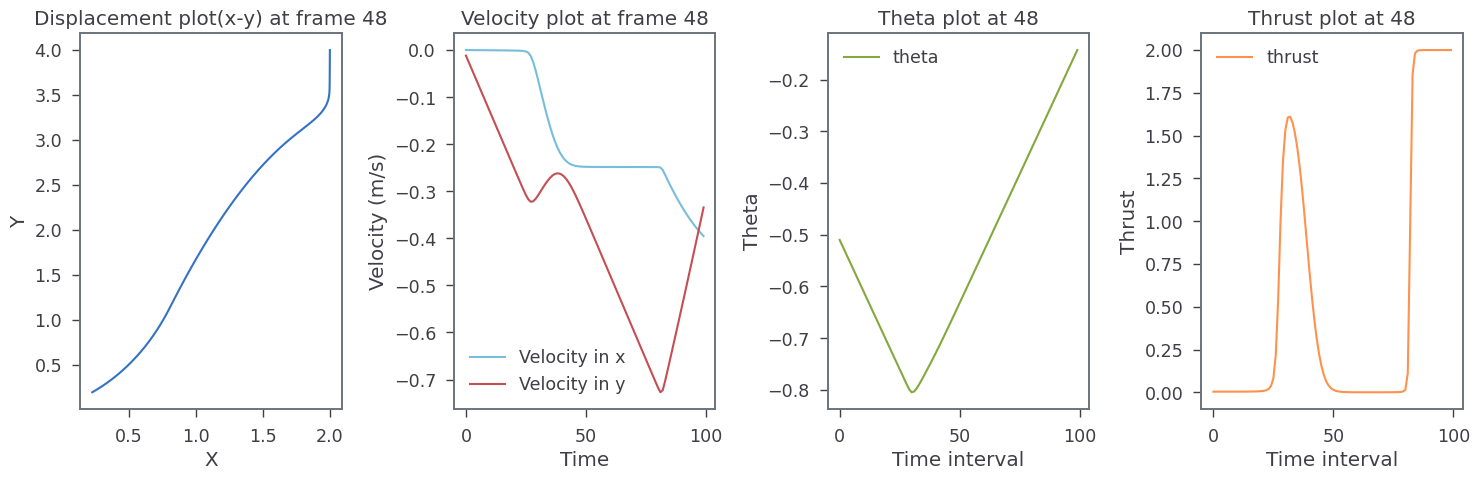

[50] loss: 0.075


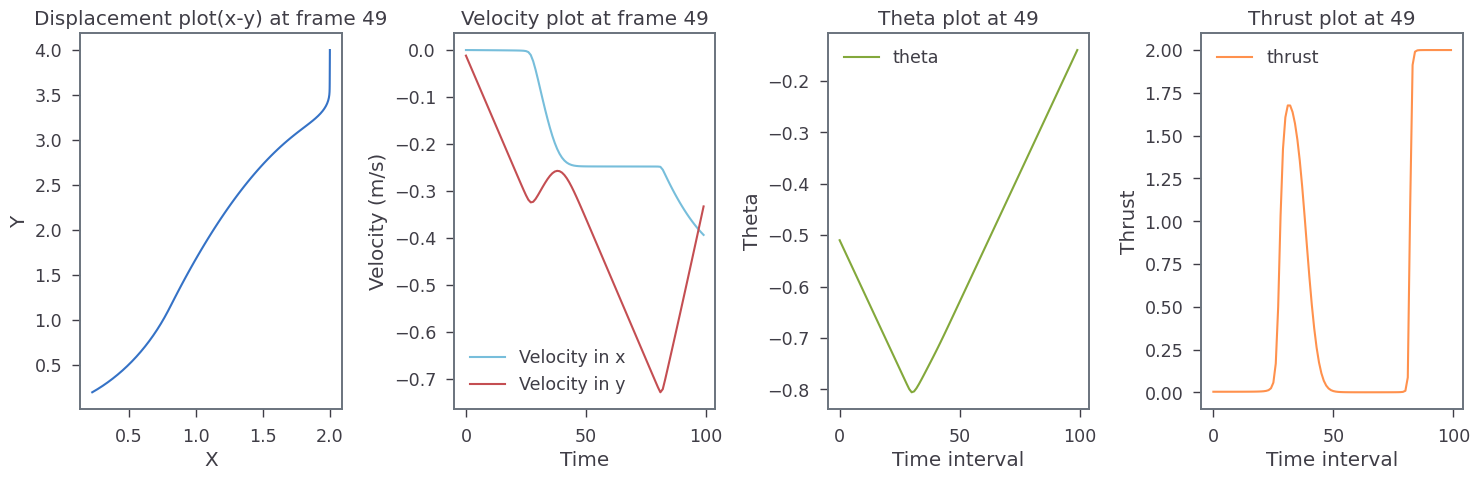

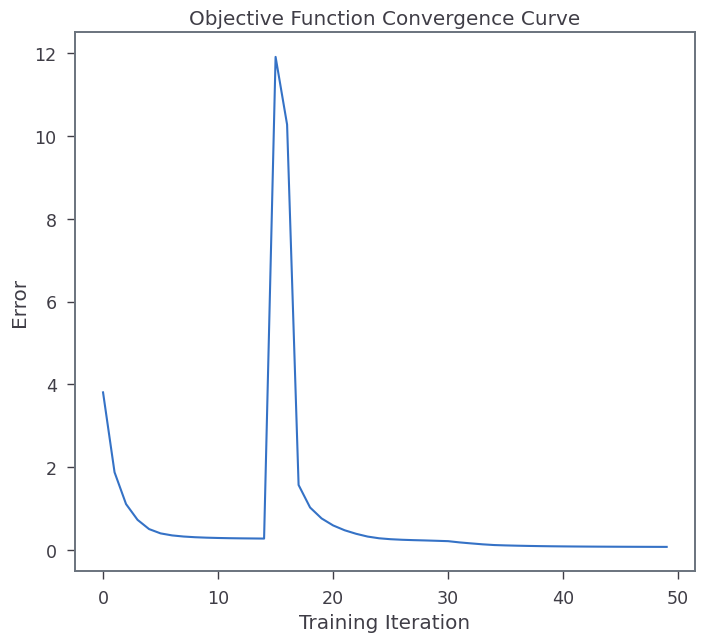

Generating Animation


IntProgress(value=0, max=101)

(100, 5) (100, 2)


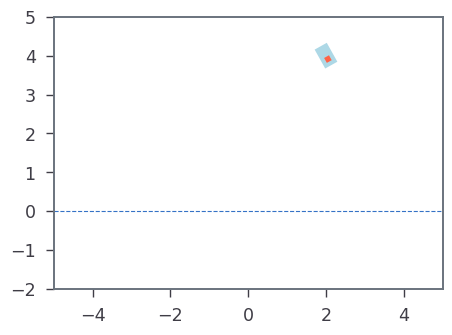

In [ ]:
T = 100  # number of time steps of the simulation
dim_input = 5  # state space dimensions
dim_hidden = 6  # latent dimensions
dim_output = 2  # action space dimensions
d = Dynamics()
c = Controller(dim_input, dim_hidden, dim_output)
s = Simulation(c, d, T)
o = Optimize(s)
o.train(50)  # training with number of epochs (gradient descent steps)